# **Binary Prediction with a Rainfall Dataset**

## **Overview**

Welcome to the 2025 Kaggle Playground Series! We plan to continue in the spirit of previous playgrounds, providing interesting and approachable datasets for our community to practice their machine learning skills, and anticipate a competition each month.

## **Problem definition**

### **Goal**

Your goal is to **predict rainfall** for each day of the year.

### **Evaluation**

Submissions are evaluated on [area under the ROC curve](http://en.wikipedia.org/wiki/Receiver_operating_characteristic) between the predicted probability and the observed target.

### **Submission File**

For each id in the test set, you must predict a probability for the target rainfall. The file should contain a header and have the following format:
```
id,rainfall
2190,0.5
2191,0.1
2192,0.9
etc.
```

### **Timeline**

- Start Date - March 1, 2025
- Entry Deadline - Same as the Final Submission Deadline
- Team Merger Deadline - Same as the Final Submission Deadline
- Final Submission Deadline - March 31, 2025

All deadlines are at 11:59 PM UTC on the corresponding day unless otherwise noted. The competition organizers reserve the right to update the contest timeline if they deem it necessary.

### **About the Tabular Playground Series**

The goal of the Tabular Playground Series is to provide the Kaggle community with a variety of fairly light-weight challenges that can be used to learn and sharpen skills in different aspects of machine learning and data science. The duration of each competition will generally only last a few weeks, and may have longer or shorter durations depending on the challenge. The challenges will generally use fairly light-weight datasets that are synthetically generated from real-world data, and will provide an opportunity to quickly iterate through various model and feature engineering ideas, create visualizations, etc.

#### **Synthetically-Generated Datasets**

Using synthetic data for Playground competitions allows us to strike a balance between having real-world data (with named features) and ensuring test labels are not publicly available. This allows us to host competitions with more interesting datasets than in the past. While there are still challenges with synthetic data generation, the state-of-the-art is much better now than when we started the Tabular Playground Series two years ago, and that goal is to produce datasets that have far fewer artifacts. Please feel free to give us feedback on the datasets for the different competitions so that we can continue to improve!

### **Prizes**

- 1st Place - Choice of Kaggle merchandise
- 2nd Place - Choice of Kaggle merchandise
- 3rd Place - Choice of Kaggle merchandise

**Please note**: In order to encourage more participation from beginners, Kaggle merchandise will only be awarded once per person in this series. If a person has previously won, we'll skip to the next team.

### **Citation**

Walter Reade and Elizabeth Park. Binary Prediction with a Rainfall Dataset. https://kaggle.com/competitions/playground-series-s5e3, 2025. Kaggle.

### **Dataset Description**

The dataset for this competition (both train and test) was generated from a deep learning model trained on the [Rainfall Prediction using Machine Learning](https://www.kaggle.com/datasets/subho117/rainfall-prediction-using-machine-learning) dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

**Files**

- **train.csv** - the training dataset; rainfall is the binary target
- **test.csv** - the test dataset; your objective is to predict the probability of rainfall for each row
- **sample_submission.csv** - a sample submission file in the correct format.


### **Metadata**

#### **Licence**

[MIT](https://www.mit.edu/~amini/LICENSE.md)

## **Importing necessary libraries**

In [2]:
# Installing the xgboost library using the 'pip' command.
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [298]:
# pandas
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

# To scale the data using z-score
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

# Algorithms to use
from sklearn import tree

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

# Importing the XGBClassifier from the xgboost library
from xgboost import XGBClassifier
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold

# Metrics to evaluate the model
from sklearn import metrics

from sklearn.metrics import confusion_matrix, classification_report,recall_score,precision_score, accuracy_score

# For tuning the model
from sklearn.model_selection import GridSearchCV


# To suppress scientific notations
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To ignore warnings
#import warnings
#warnings.filterwarnings("ignore")

## **Loading the dataset**

In [299]:
# For Colab
#from google.colab import drive
#drive.mount('/content/drive')
#data_directory="/content/drive/MyDrive/Shinhacker/data/"
#results_directory = "/content/drive/MyDrive/Shinhacker/working/"

In [300]:
#path='/kaggle/input/playground-series-s5e2/'
path_input ='./data'
path_output = './working'

In [395]:
# Define constants for attribute names.
columns = (
  'id', 'day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed', 'rainfall'
)
# Upper case constants for variables.
for (v, w) in zip(map(str.upper, columns), columns):
    exec("%s = '%s'" % (v, w))

# Read in the data.
train_df = pd.read_csv(
    '/'.join([path_input,'train.csv']),                # Path to input file.
    header = 0,                                        # Header in line 0.
    names = columns,                                   # Column labels defined.
    index_col = ID,                                    # ID column used for index.
    usecols = columns,                                 # Specify colomns to import.
    skipinitialspace=True,                             # Skip space around ends.
    encoding = "ascii",                                # Assume ascii encoding for input data.
)
test_df = pd.read_csv(
    '/'.join([path_input, 'test.csv']),                # Path to input file.
    header = 0,                                        # Header in line 0.
    names = columns[:-1],                              # Column labels defined.
    index_col = ID,                                    # ID column used for index.
    usecols = columns[:-1],                            # Specify colomns to import.
    skipinitialspace=True,                             # Skip space around ends.
    encoding = "ascii",                                # Assume ascii encoding for input data.
)

## **Checking the dataset**

In [396]:
train_df.shape, test_df.shape

((2190, 12), (730, 11))

In [397]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2190 entries, 0 to 2189
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            2190 non-null   int64  
 1   pressure       2190 non-null   float64
 2   maxtemp        2190 non-null   float64
 3   temparature    2190 non-null   float64
 4   mintemp        2190 non-null   float64
 5   dewpoint       2190 non-null   float64
 6   humidity       2190 non-null   float64
 7   cloud          2190 non-null   float64
 8   sunshine       2190 non-null   float64
 9   winddirection  2190 non-null   float64
 10  windspeed      2190 non-null   float64
 11  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(2)
memory usage: 222.4 KB


In [398]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 730 entries, 2190 to 2919
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            730 non-null    int64  
 1   pressure       730 non-null    float64
 2   maxtemp        730 non-null    float64
 3   temparature    730 non-null    float64
 4   mintemp        730 non-null    float64
 5   dewpoint       730 non-null    float64
 6   humidity       730 non-null    float64
 7   cloud          730 non-null    float64
 8   sunshine       730 non-null    float64
 9   winddirection  729 non-null    float64
 10  windspeed      730 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 68.4 KB


In [399]:
train_df.nunique(),test_df.nunique()

(day              365
 pressure         236
 maxtemp          219
 temparature      198
 mintemp          199
 dewpoint         218
 humidity          49
 cloud             78
 sunshine         120
 winddirection     35
 windspeed        223
 rainfall           2
 dtype: int64,
 day              365
 pressure         185
 maxtemp          182
 temparature      175
 mintemp          171
 dewpoint         172
 humidity          42
 cloud             69
 sunshine         110
 winddirection     29
 windspeed        205
 dtype: int64)

In [400]:
train_df.describe()

day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  \
count 2190.000  2190.000 2190.000     2190.000 2190.000  2190.000  2190.000   
mean   179.948  1013.602   26.366       23.953   22.170    20.455    82.037   
std    105.204     5.655    5.654        5.222    5.059     5.288     7.801   
min      1.000   999.000   10.400        7.400    4.000    -0.300    39.000   
25%     89.000  1008.600   21.300       19.300   17.700    16.800    77.000   
50%    178.500  1013.000   27.800       25.500   23.850    22.150    82.000   
75%    270.000  1017.775   31.200       28.400   26.400    25.000    88.000   
max    365.000  1034.600   36.000       31.500   29.800    26.700    98.000   

         cloud  sunshine  winddirection  windspeed  rainfall  
count 2190.000  2190.000       2190.000   2190.000  2190.000  
mean    75.722     3.744        104.863     21.805     0.753  
std     18.026     3.626         80.002      9.899     0.431  
min      2.000     0.000         10.000      4.400     0.000  
25%     69.000     0.400         40.000     14.125     1.000  
50%     83.000     2.400         70.000     20.500     1.000  
75%     88.000     6.800        200.000     27.900     1.000  
max    100.000    12.100        300.000     59.500     1.000

In [401]:
test_df.describe()

day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  \
count 730.000   730.000  730.000      730.000  730.000   730.000   730.000   
mean  183.000  1013.503   26.372       23.963   22.110    20.460    82.670   
std   105.438     5.506    5.673        5.278    5.171     5.391     7.819   
min     1.000  1000.000    7.400        5.900    4.200    -0.000    39.000   
25%    92.000  1008.725   21.600       19.825   17.825    16.800    77.250   
50%   183.000  1012.700   27.800       25.650   23.900    22.300    82.000   
75%   274.000  1017.600   31.000       28.375   26.400    25.000    89.000   
max   365.000  1032.200   35.800       31.800   29.100    26.700    98.000   

        cloud  sunshine  winddirection  windspeed  
count 730.000   730.000        729.000    730.000  
mean   76.360     3.664        103.923     22.484  
std    17.934     3.639         81.695      9.955  
min     0.000     0.000         10.000      4.500  
25%    69.000     0.325         40.000     14.500  
50%    83.000     2.200         70.000     21.300  
75%    88.000     6.675        200.000     28.400  
max   100.000    11.800        300.000     59.500

In [402]:
# Fix discontinous days (use the fact that the indecies go from 0 with increment of 1).
train_df = train_df.assign(**{
    DAY: lambda x: np.array(x.index.to_list())%365+1
})
test_df = test_df.assign(**{
    DAY: lambda x: np.array(x.index.to_list())%365+1
})    

In [403]:
# interpolate missing winddirection data point (only single point so not fancy)
idx_fix = 2707
idx_show = idx_fix + np.array([-3,-2,-1,0,1,2,3])
display(test_df.loc[idx_show])
test_df.loc[idx_fix] = (100+220)/2//10*10
display(test_df.loc[idx_show])

day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  cloud  \
id                                                                              
2704  150  1006.100   34.000       30.200   27.400    24.200    70.000 48.000   
2705  151  1008.400   34.400       30.000   27.800    24.800    72.000 22.000   
2706  152  1007.600   33.100       30.400   28.900    25.900    81.000 87.000   
2707  153  1007.800   32.900       30.600   28.900    22.000    65.000 75.000   
2708  154  1008.600   33.700       30.500   28.200    25.000    89.000 83.000   
2709  155  1009.500   33.900       30.200   27.500    25.800    74.000 30.000   
2710  156  1008.500   32.700       30.200   28.000    25.200    78.000 32.000   

      sunshine  winddirection  windspeed  
id                                        
2704     9.300         10.000     52.800  
2705    11.100        230.000     25.200  
2706     1.600        100.000     35.300  
2707     8.200            NaN     17.200  
2708     3.900        220.000     11.700  
2709    10.800        220.000     15.800  
2710    10.800         50.000      7.900

day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  \
id                                                                       
2704  150  1006.100   34.000       30.200   27.400    24.200    70.000   
2705  151  1008.400   34.400       30.000   27.800    24.800    72.000   
2706  152  1007.600   33.100       30.400   28.900    25.900    81.000   
2707  160   160.000  160.000      160.000  160.000   160.000   160.000   
2708  154  1008.600   33.700       30.500   28.200    25.000    89.000   
2709  155  1009.500   33.900       30.200   27.500    25.800    74.000   
2710  156  1008.500   32.700       30.200   28.000    25.200    78.000   

       cloud  sunshine  winddirection  windspeed  
id                                                
2704  48.000     9.300         10.000     52.800  
2705  22.000    11.100        230.000     25.200  
2706  87.000     1.600        100.000     35.300  
2707 160.000   160.000        160.000    160.000  
2708  83.000     3.900        220.000     11.700  
2709  30.000    10.800        220.000     15.800  
2710  32.000    10.800         50.000      7.900

In [404]:
# Continuous numeric travel data: AGE, TRAVEL_DIST, DEP_DELAY, ARR_DELAY
def plot_dist(data,w=15,h=5,nbins=30,title=None,xlabel=None,ylabel=None):
    fig, (axsU, axsM, axsL) = plt.subplots(3, 1, figsize=(w,h)) #, sharex=True)
    axsU.sharex(axsM)
    skew = f"(skew = {data.skew():#,.2g}".removesuffix(".") + ")"
    # Add title
    if (title):
        fig.suptitle(f"{title} {skew}")
    else:
        fig.suptitle(f"Distribution of {data.name} {skew}")
    sns.histplot(x=data,ax=axsM, kde=True, bins=nbins)
    sns.boxplot(x=data,ax=axsU)
    # Calculate mean and median and add them as labels.
    q25, median, q75, mean = (data.quantile(0.25), data.median(), data.quantile(0.75), data.mean())
    axsM.axvline(q25, color='yellow', label=f"Q1 ({q25:#,.3g}".removesuffix(".") + ")")
    axsM.axvline(median, color='red', label=f"Median ({median:#,.3g}".removesuffix(".") + ")")
    axsM.axvline(mean, color='green', label=f"Mean ({mean:#,.3g}".removesuffix(".") + ")")
    axsM.axvline(q75, color='yellow', label=f"Q4 ({q75:#,.3g}".removesuffix(".") + ")")
    axsM.legend(loc='upper right', fontsize='medium')
    # Add labels on axes.
    if (xlabel): plt.xlabel(xlabel)
    if (ylabel): plt.ylabel(ylabel)
    data.plot.line(ax=axsL)
    plt.show()

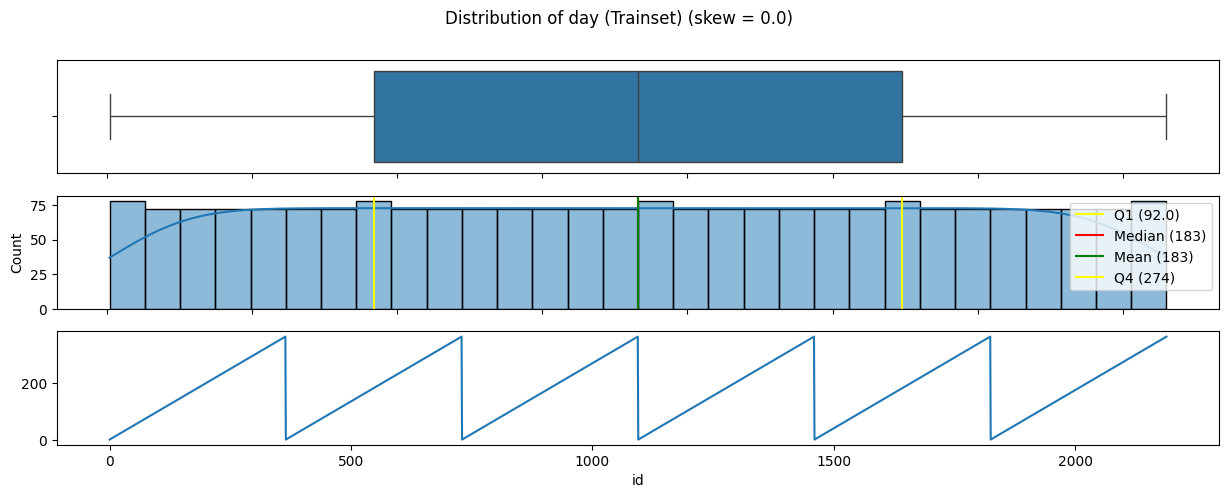

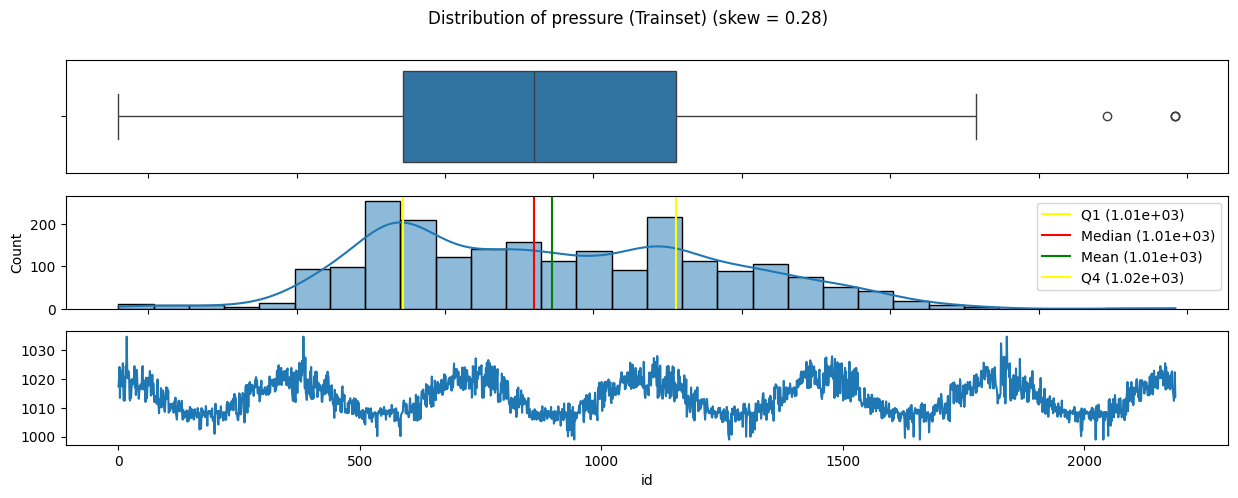

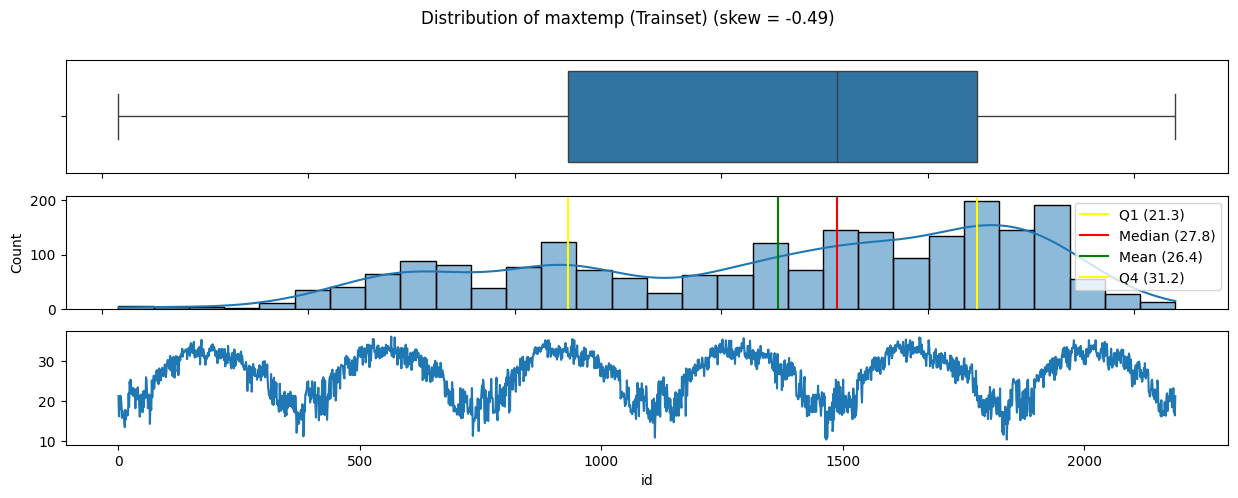

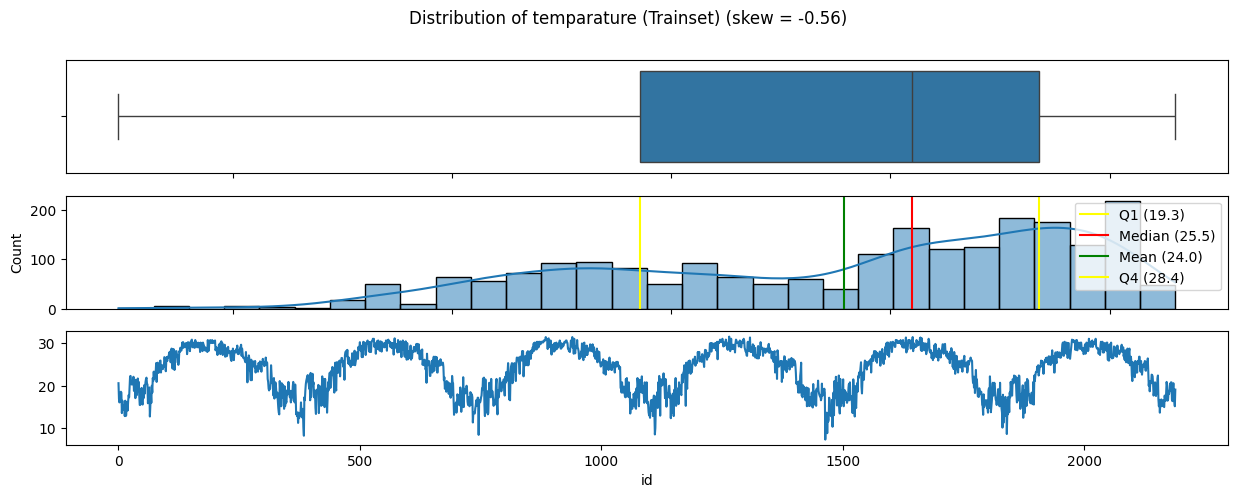

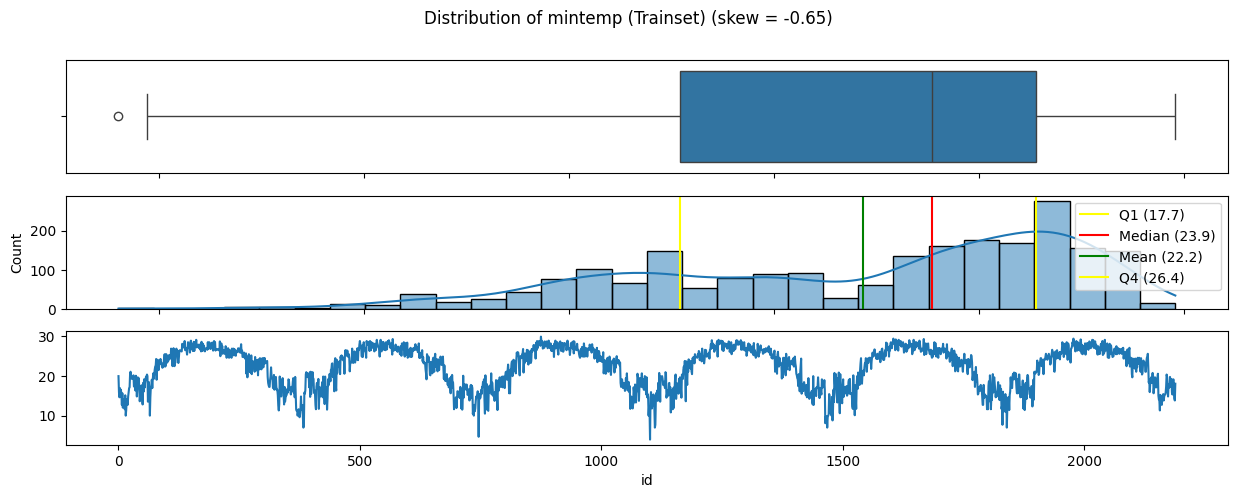

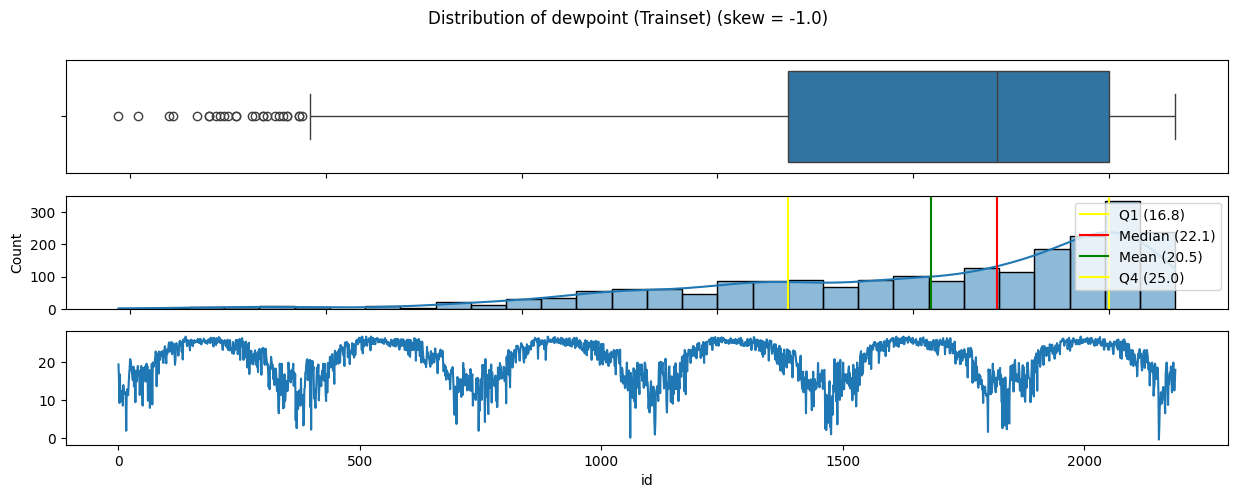

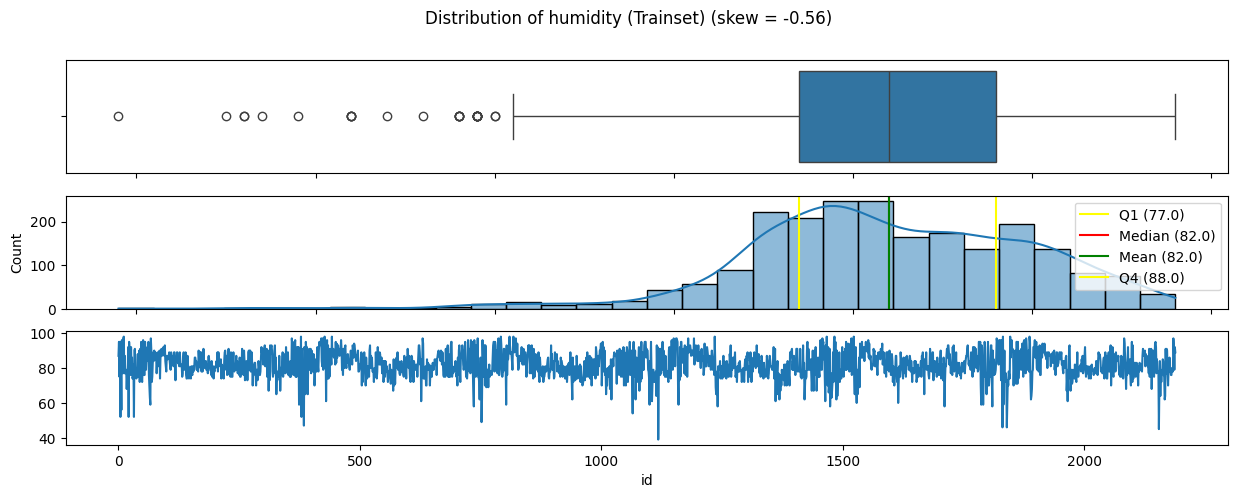

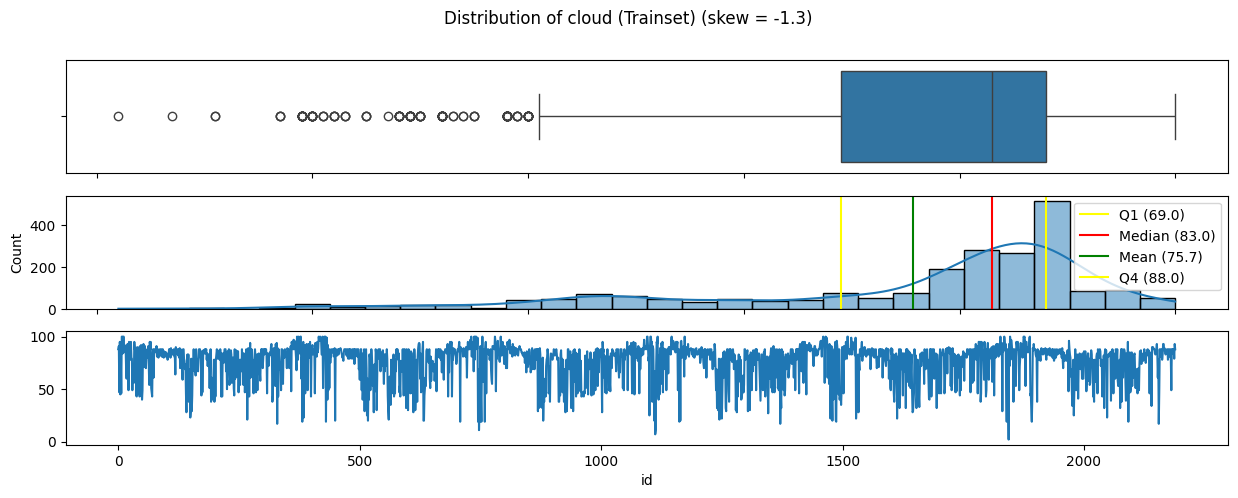

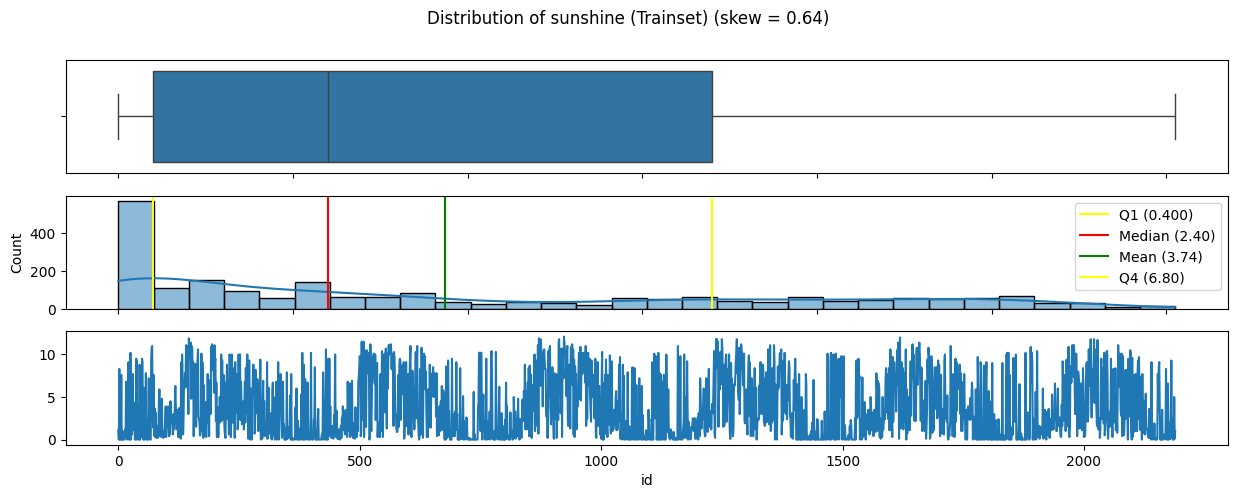

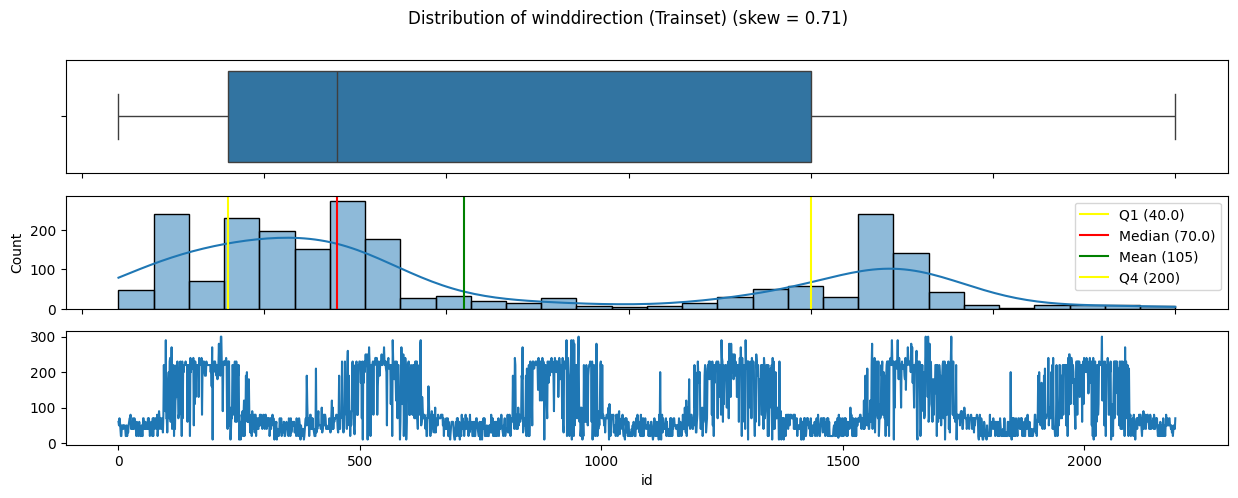

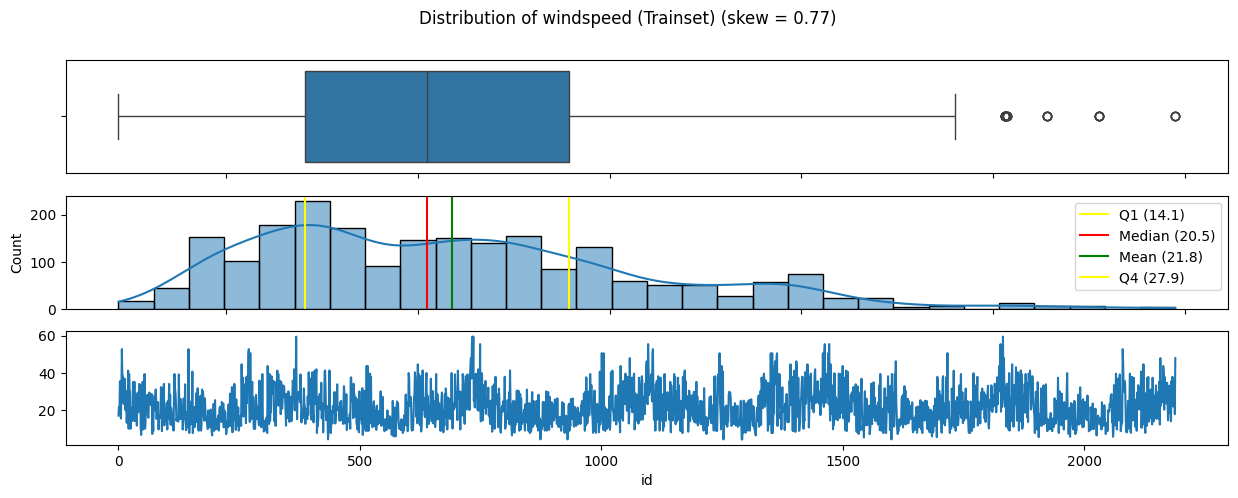

In [405]:
for c in columns[1:-1]:
    plot_dist(train_df[c], title=f"Distribution of {c} (Trainset)",xlabel=c)

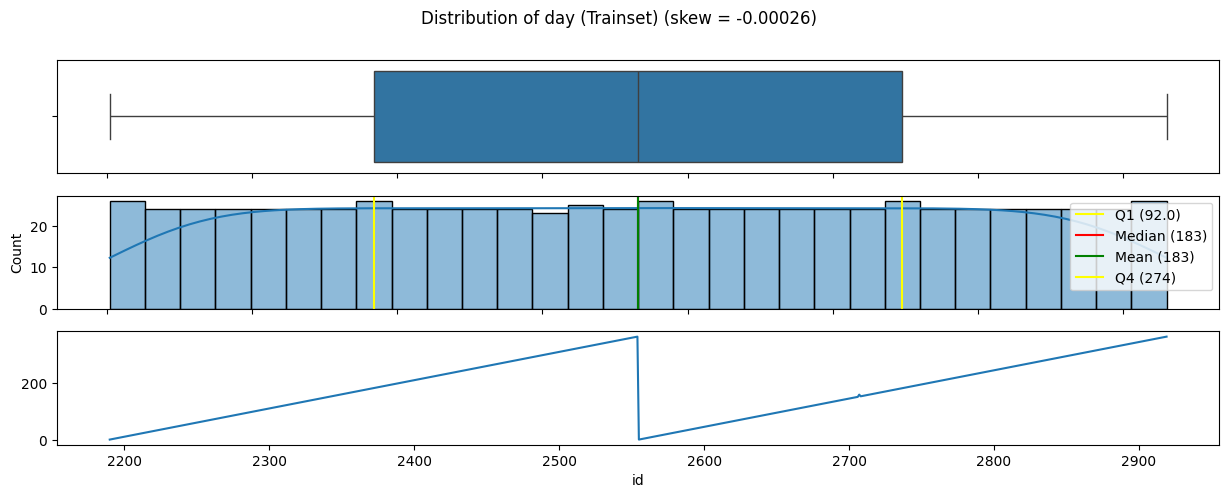

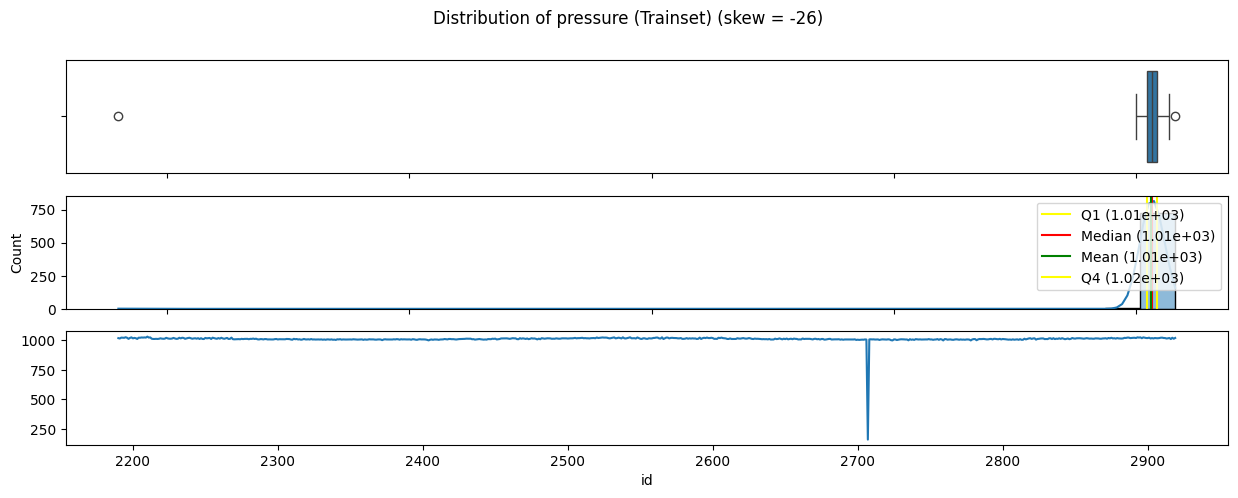

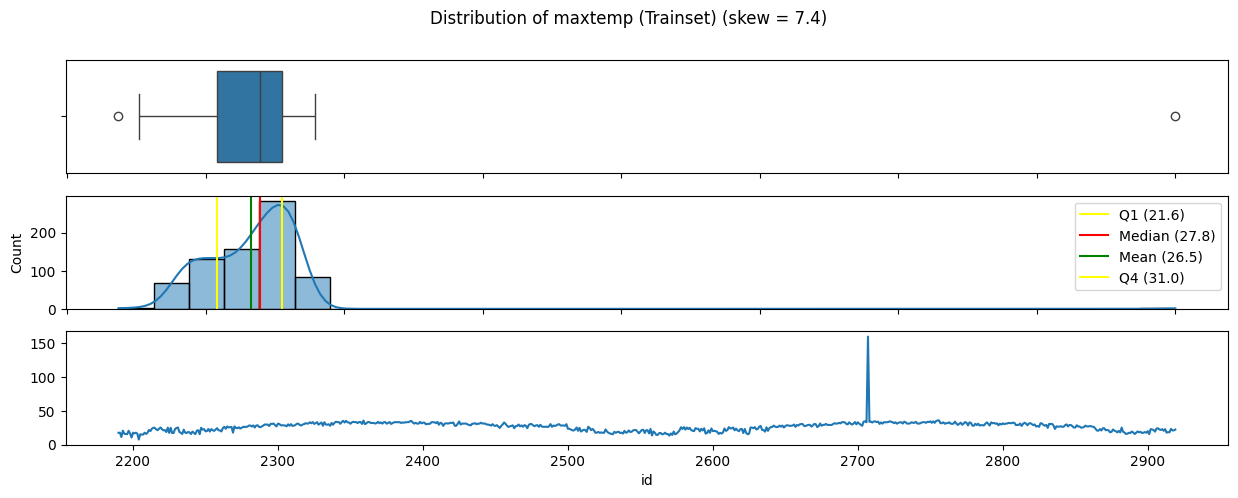

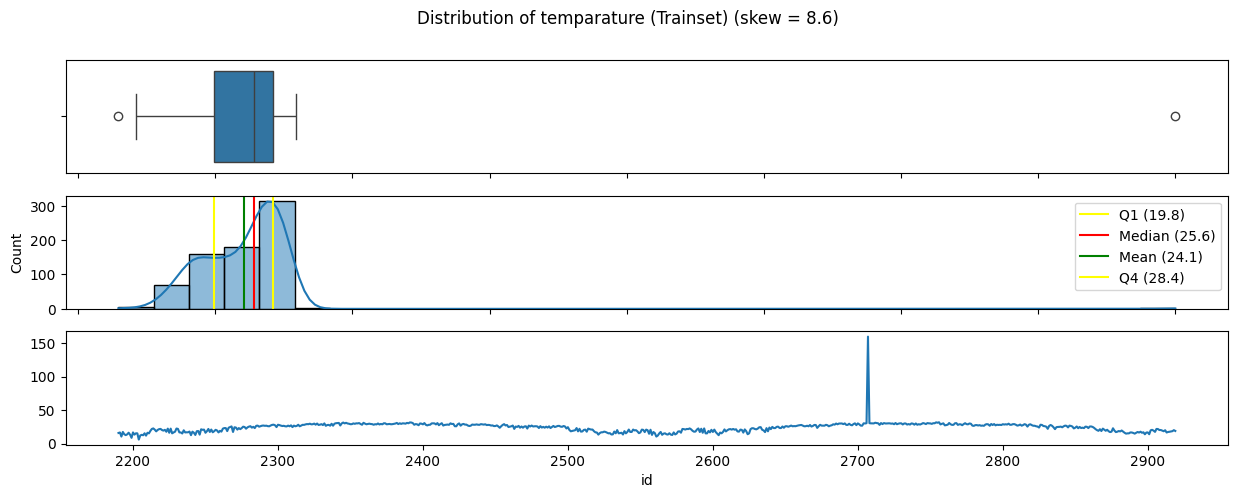

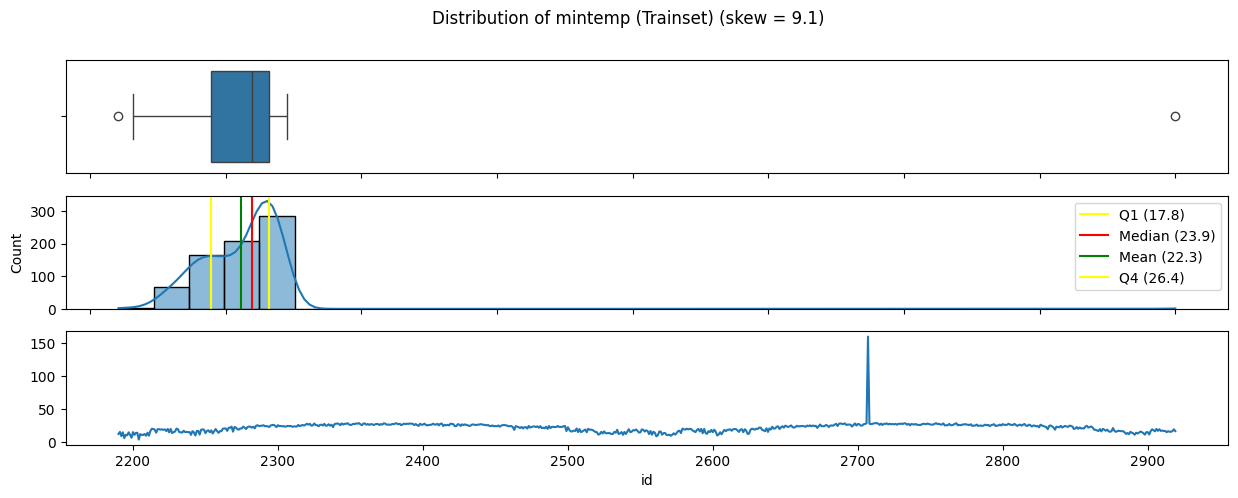

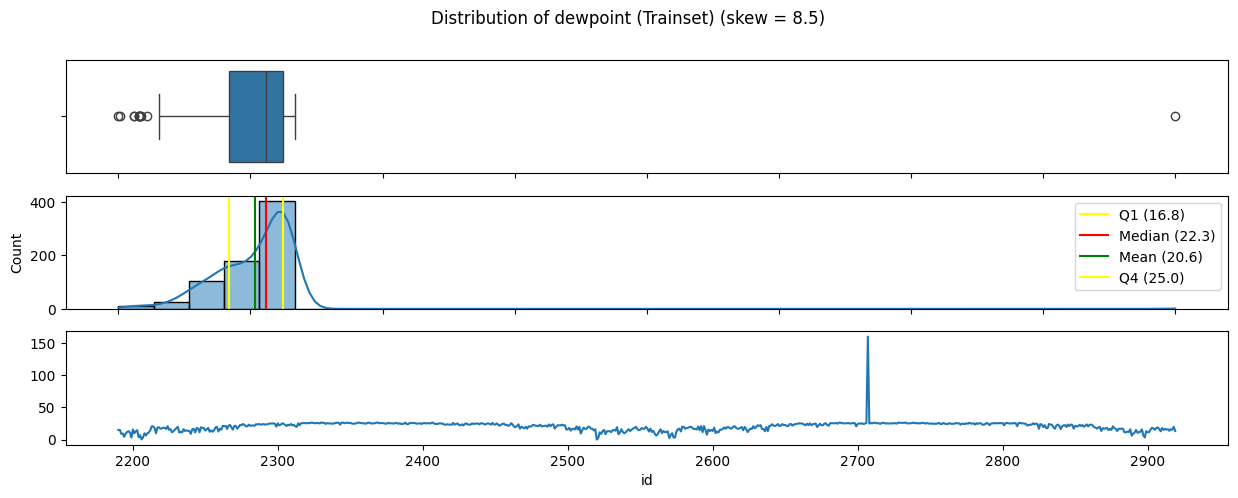

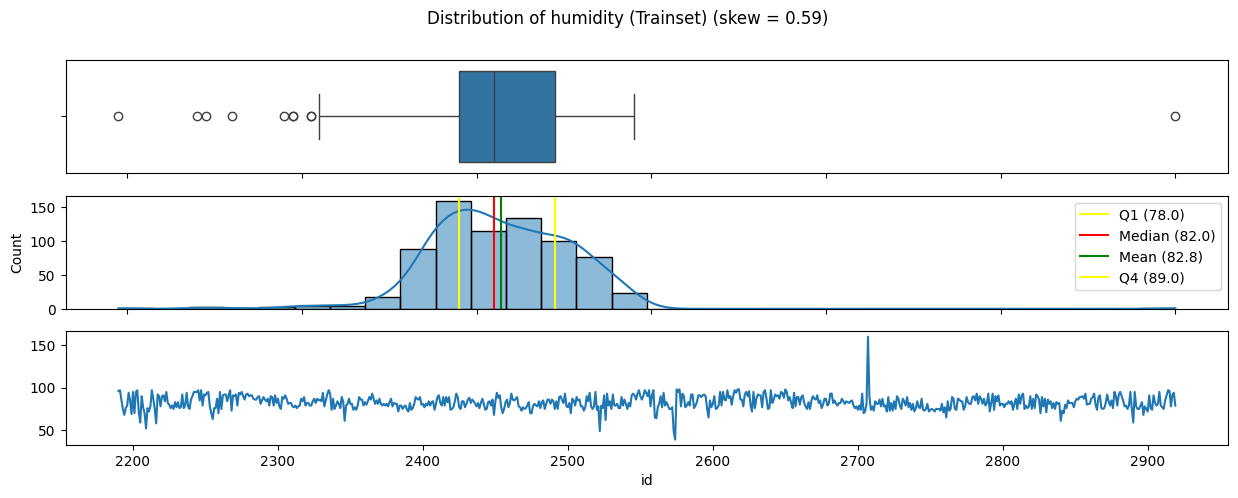

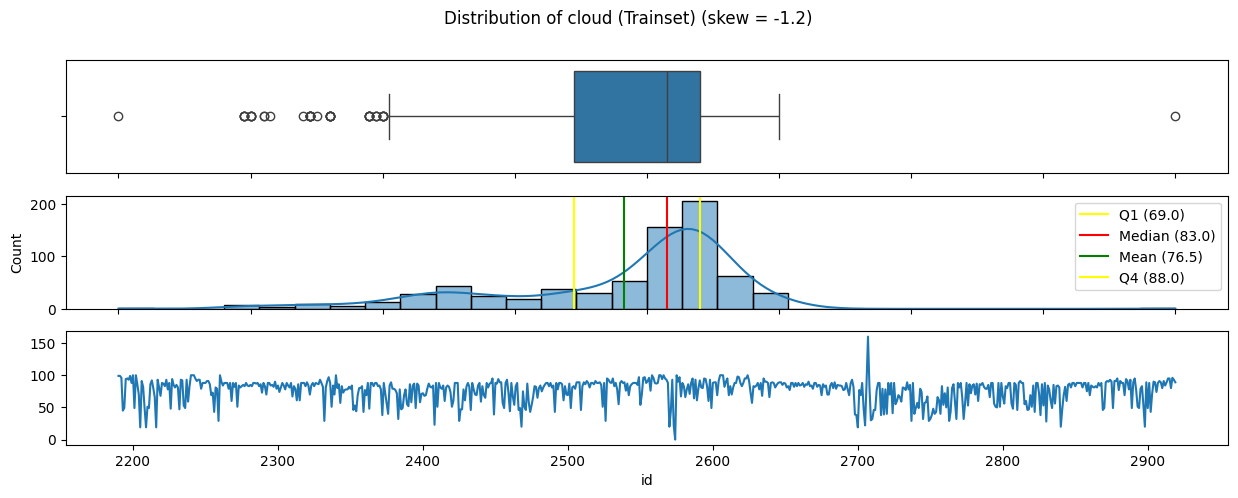

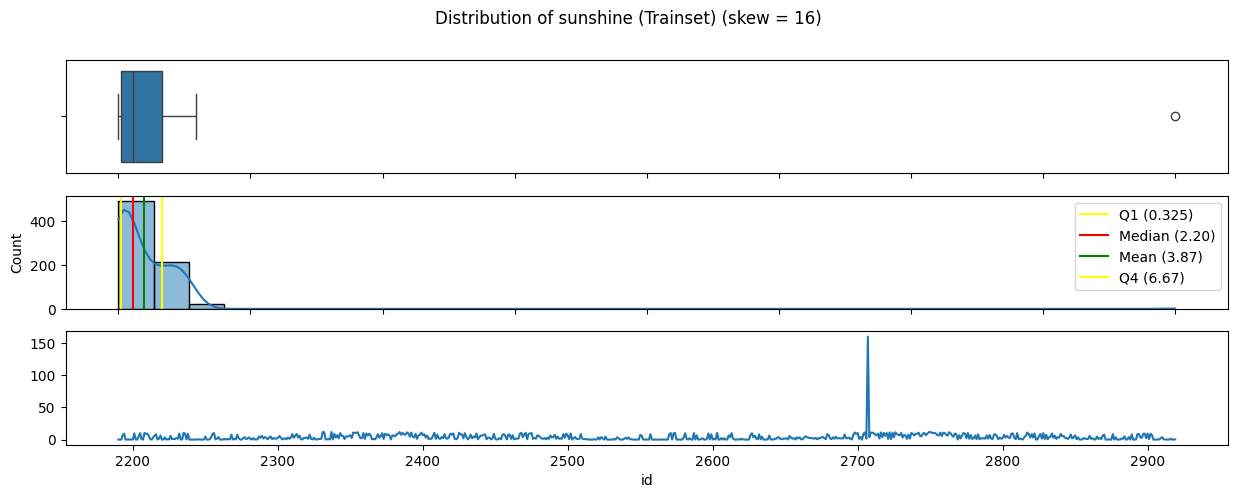

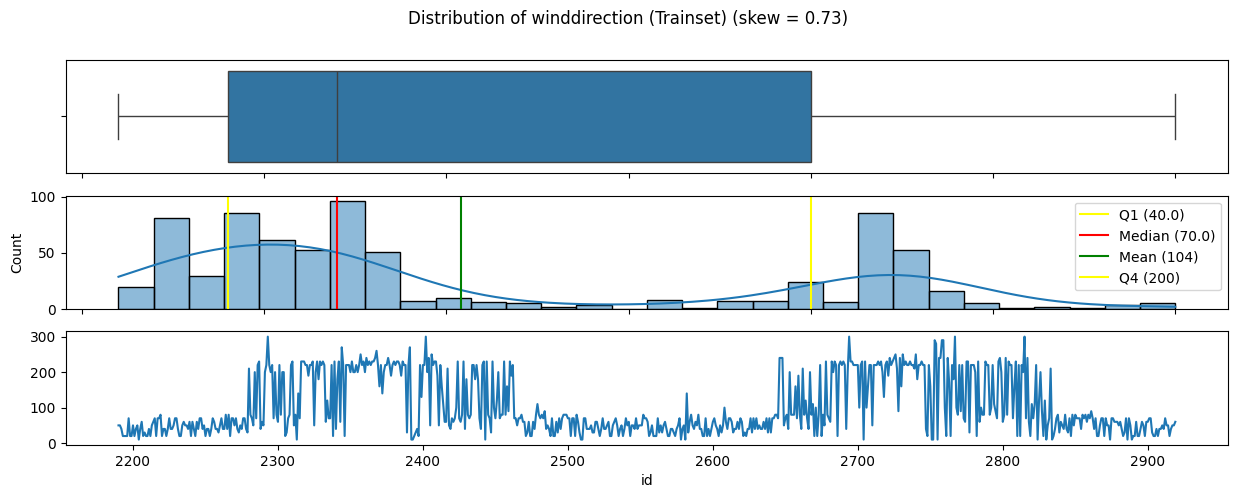

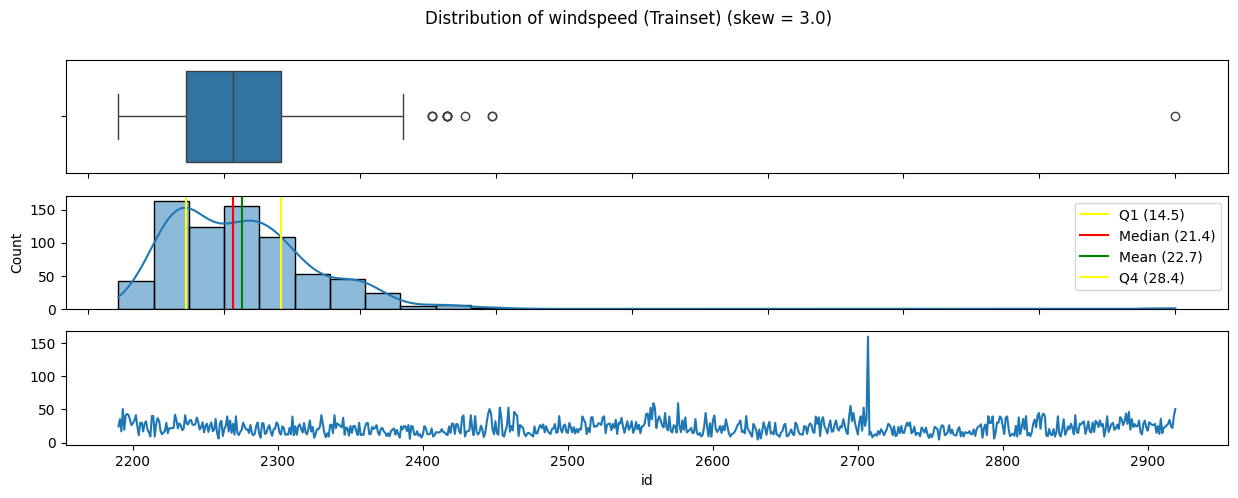

In [406]:
for c in columns[1:-1]:
    plot_dist(test_df[c], title=f"Distribution of {c} (Trainset)",xlabel=c)

## **Data Processing**

In [ ]:
# Keep IDs for values that need to be updated by models below.
columns = [
    'Customer_Type',
    'Type_Travel',
    'Arrival_Time_Convenient',
    'Catering',
    'Onboard_Service'
]
indices_all = {}
indices_test = {}
for col in columns:
    indices_all[col] = final_all.loc[final_all[col].isna()].index
    indices_test[col] = final_test.loc[final_test[col].isna()].index

In [ ]:
# Binning the Age column
bins = [0, 13, 25, 40, 65, np.inf]
names = ['0-13', '13-25', '25-40', '40-65', '65+']

final_df['Age'] = pd.cut(final_df['Age'], bins, labels = names)
final_test['Age'] = pd.cut(final_test['Age'], bins, labels = names)
final_all['Age'] = pd.cut(final_all['Age'], bins, labels = names)

In [ ]:
# Using get_dummies below instead -- set the 'encoding_method' variable accordingly.
encoding_method = 'get_dummies'  # 'get_dummies', 'factorize_rate2numeric'
# Always apply 'factorize_rate2numeric' method to these columns that are specifically modelled below.
defer_columns = ['Customer_Type', 'Type_Travel', 'Arrival_Time_Convenient', 'Catering', 'Onboard_Service']
final_df = final_df.assign(**{
  col: lambda x, c=col: pd.factorize(x[c])[0] for col in defer_columns[:2]
})
final_test = final_test.assign(**{
  col: lambda x, c=col: pd.factorize(x[c])[0] for col in defer_columns[:2]
})
final_all = final_all.assign(**{
  col: lambda x, c=col: pd.factorize(x[c])[0] for col in defer_columns[:2]
})
final_df = final_df.assign(**{
    col: lambda x, c=col: [rating_to_numeric(y) for y in x[c]] for col in defer_columns[2:] if col in final_df.columns
})
final_test = final_test.assign(**{
    col: lambda x, c=col: [rating_to_numeric(y) for y in x[c]] for col in defer_columns[2:] if col in final_test.columns
})
final_all = final_all.assign(**{
    col: lambda x, c=col: [rating_to_numeric(y) for y in x[c]] for col in defer_columns[2:] if col in final_all.columns
})

# Now treat the rest
match encoding_method:
    case 'factorize_rate2numeric':
        # Convert rating text to number
        survey_cols = survey_df.columns.drop([*defer_columns[2:], 'Overall_Experience', 'Seat_Class'])

        final_df = final_df.assign(**{
            col: lambda x, c=col: [rating_to_numeric(y) for y in x[c]] for col in survey_cols if col in final_df.columns
        })
        final_test = final_test.assign(**{
            col: lambda x, c=col: [rating_to_numeric(y) for y in x[c]] for col in survey_cols if col in final_test.columns
        })
        final_all = final_all.assign(**{
            col: lambda x, c=col: [rating_to_numeric(y) for y in x[c]] for col in survey_cols if col in final_all.columns
        })

        # Encoding the categorical columns
        factorize_columns = ['Gender', 'Age', 'Travel_Class', 'Seat_Class']
        final_df = final_df.assign(**{
          col: lambda x, c=col: pd.factorize(x[c])[0] for col in factorize_columns
        })
        final_test = final_test.assign(**{
          col: lambda x, c=col: pd.factorize(x[c])[0] for col in factorize_columns
        })
        final_all = final_all.assign(**{
          col: lambda x, c=col: pd.factorize(x[c])[0] for col in factorize_columns
        })

    case 'get_dummies':
        dummy_columns = final_all.select_dtypes(exclude='number').columns.tolist()
        if 'Overall_Experience' in dummy_columns: dummy_columns.remove('Overall_Experience') # better not touch this one
        # We process these later - so we need them sharp!
        for d in defer_columns:
            if (d in dummy_columns): dummy_columns.remove(d)
        final_df = pd.get_dummies(final_df, columns=dummy_columns, dtype=int)
        final_test = pd.get_dummies(final_test, columns=dummy_columns, dtype=int)
        final_all = pd.get_dummies(final_all, columns=dummy_columns, dtype=int)
        # Add zero columns to data frames with missing columns after call to get_dummie (where categorial values were missing)
        # Needed when combining datasets below and to make test dataset compatible.
        cols = set(final_test.columns).union(set(final_all.columns)).union(set(final_df.columns))
        cols.discard('Overall_Experience')
        final_df = final_df.assign(**{ col: 0 for col in cols.difference(set(final_df.columns.tolist())) })
        final_test = final_test.assign(**{ col: 0 for col in cols.difference(set(final_test.columns.tolist())) })
        final_all = final_all.assign(**{ col: 0 for col in cols.difference(set(final_all.columns.tolist())) })
        # Also remove spaces in new column names
        final_df.rename(columns=lambda x: x.replace(" ","_"), inplace=True)
        final_test.rename(columns=lambda x: x.replace(" ","_"), inplace=True)
        final_all.rename(columns=lambda x: x.replace(" ","_"), inplace=True)
    case _:
        pass

# Printing 10 observations
final_df.sample(10)

Customer_Type  Type_Travel  Travel_Distance  \
ID                                                      
98833879              0            1             3984   
98892211              0            1              815   
98846555             -1            1             2577   
98873072              0            0             3043   
98838238              0            1              213   
98817849              1            1             2210   
98873851              1            1             2280   
98832979              1            1             1867   
98883126              0            1             3431   
98826524              0            1             2246   

          Departure_Delay_in_Mins  Arrival_Delay_in_Mins  Overall_Experience  \
ID                                                                             
98833879                      0.0                    0.0                   1   
98892211                      0.0                    0.0                   0   
98846555                      7.0                    0.0                   1   
98873072                      0.0                    0.0                   1   
98838238                      0.0                    0.0                   0   
98817849                      0.0                    0.0                   0   
98873851                     69.0                   60.0                   0   
98832979                     17.0                   11.0                   0   
98883126                    242.0                  278.0                   0   
98826524                      9.0                    2.0                   0   

          Arrival_Time_Convenient  Catering  Onboard_Service  Gender_Female  \
ID                                                                            
98833879                      5.0       5.0              4.0              0   
98892211                      1.0       1.0              2.0              1   
98846555                      4.0       4.0              5.0              0   
98873072                      4.0       4.0              1.0              1   
98838238                      3.0       NaN              3.0              1   
98817849                      2.0       2.0              3.0              1   
98873851                      NaN       2.0              3.0              1   
98832979                      5.0       2.0              2.0              1   
98883126                      5.0       5.0              3.0              0   
98826524                      4.0       4.0              NaN              0   

          ...  Cleanliness_Extremely_Poor  Cleanliness_Good  \
ID        ...                                                 
98833879  ...                           0                 1   
98892211  ...                           0                 0   
98846555  ...                           0                 1   
98873072  ...                           0                 0   
98838238  ...                           0                 0   
98817849  ...                           0                 0   
98873851  ...                           0                 0   
98832979  ...                           0                 0   
98883126  ...                           0                 0   
98826524  ...                           0                 0   

          Cleanliness_Needs_Improvement  Cleanliness_Poor  \
ID                                                          
98833879                              0                 0   
98892211                              1                 0   
98846555                              0                 0   
98873072                              0                 0   
98838238                              0                 0   
98817849                              0                 0   
98873851                              0                 0   
98832979                              1                 0   
98883126                              0         

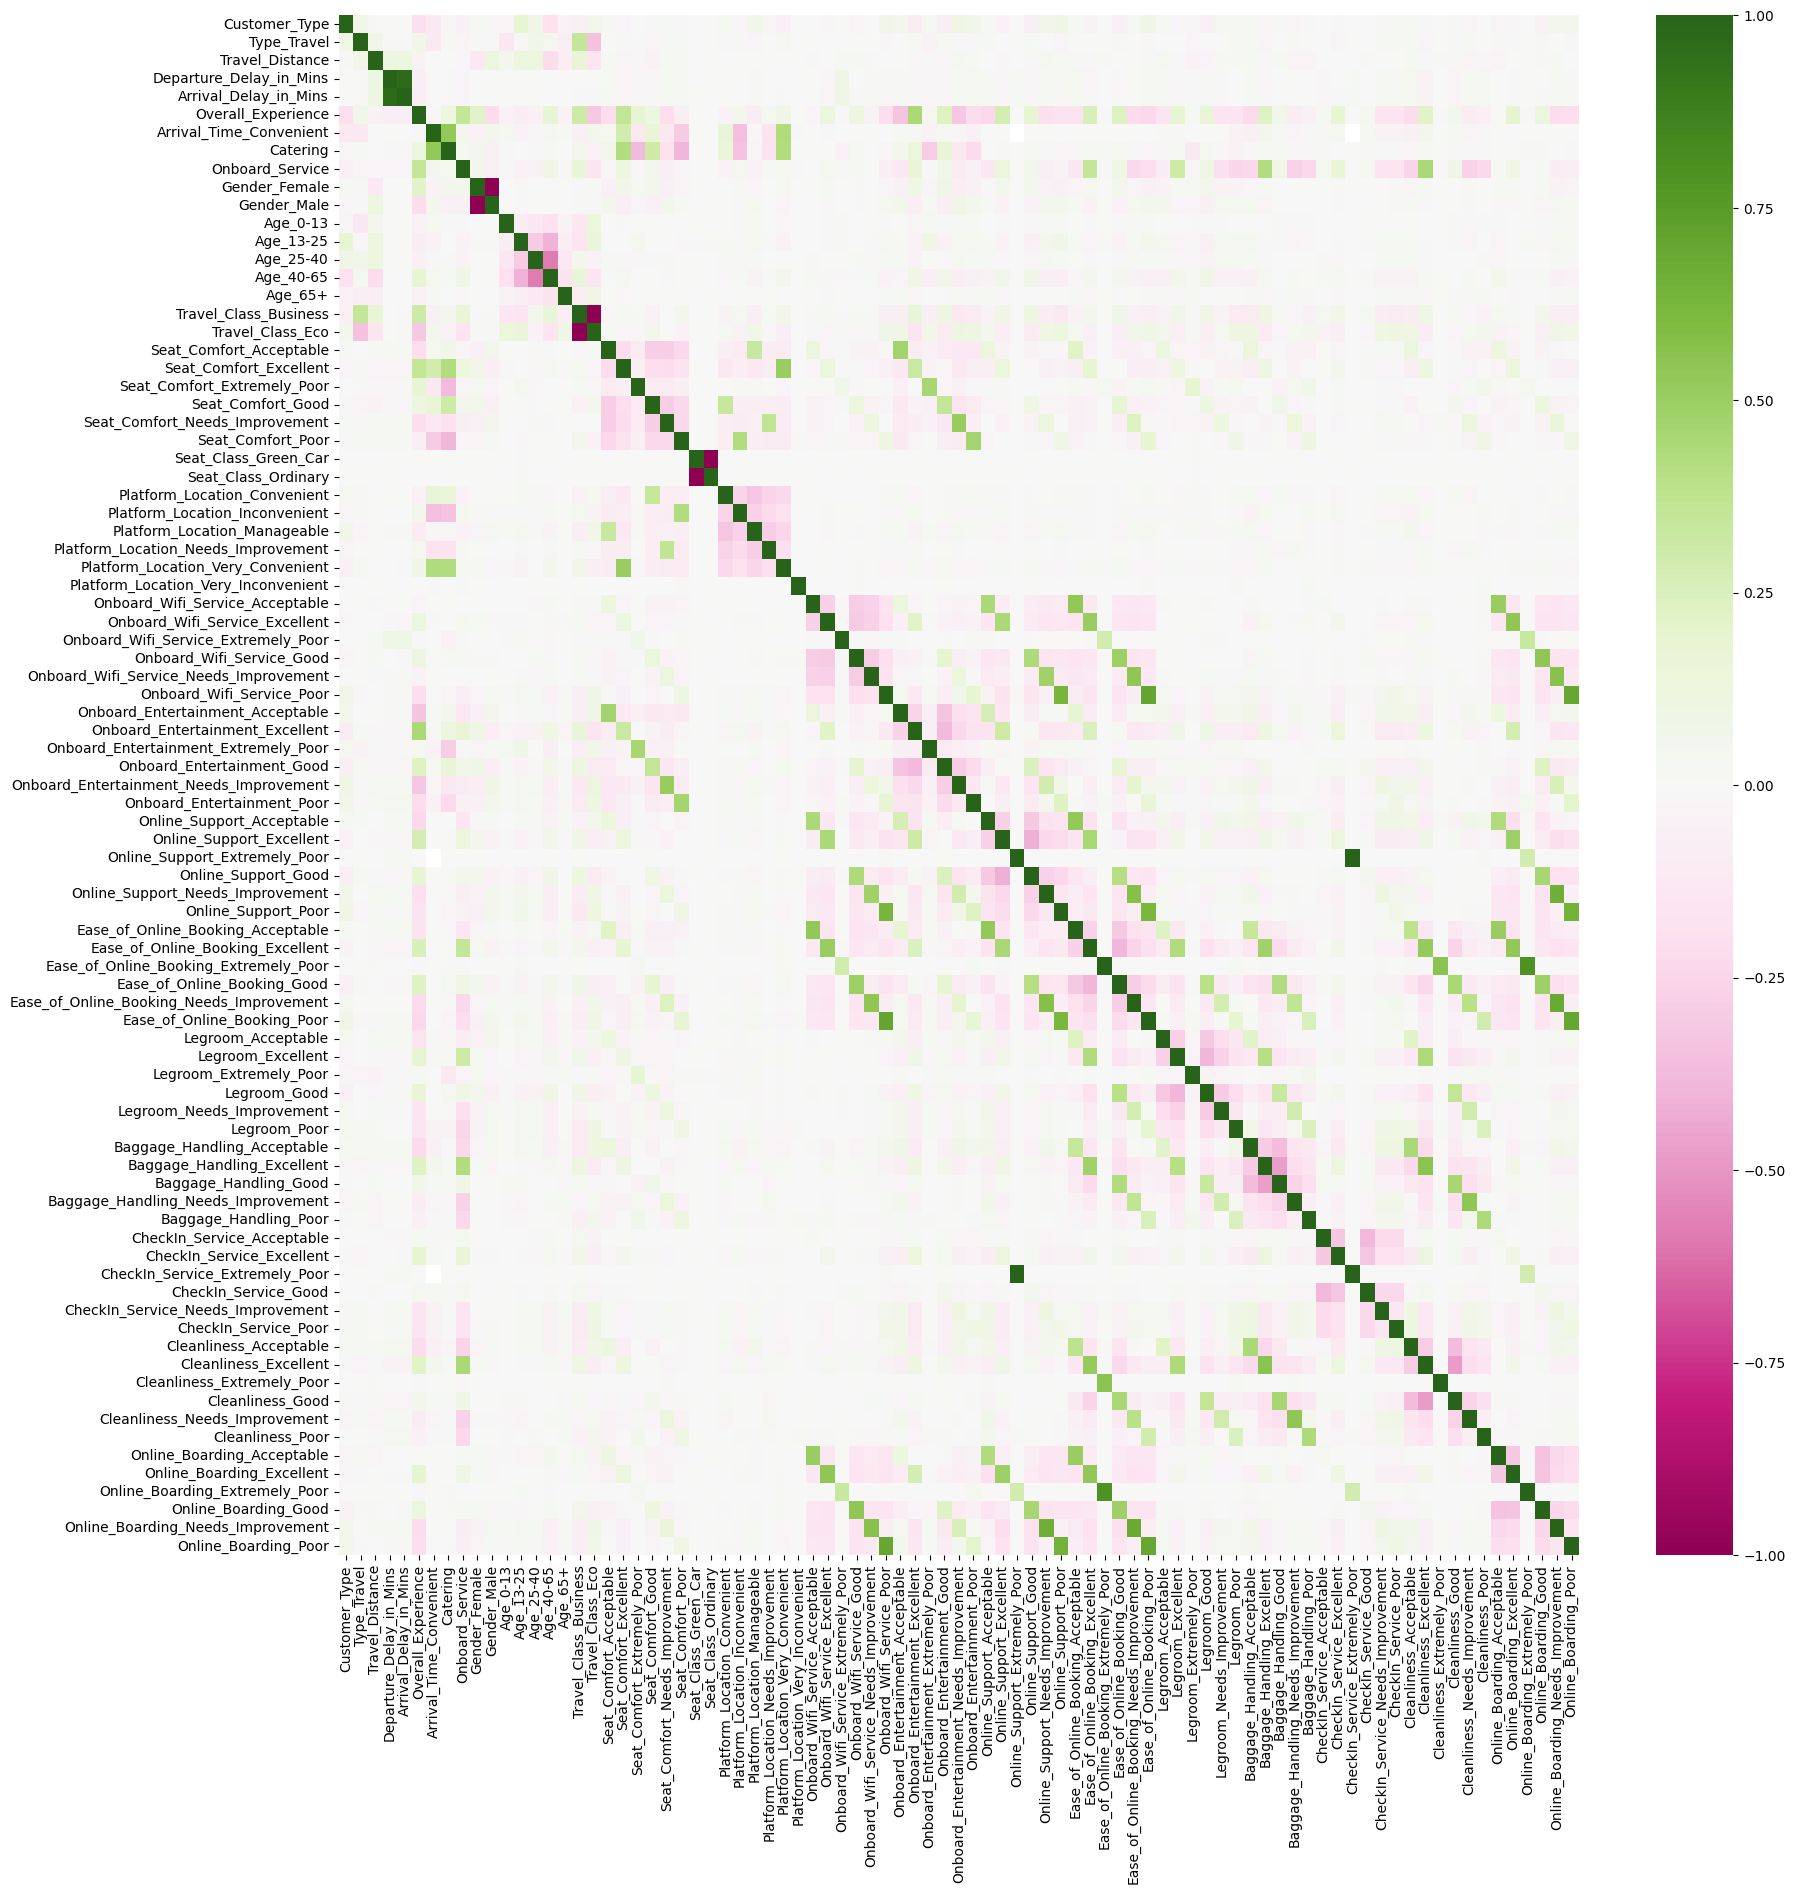

In [ ]:
plt.figure(figsize  = (20, 20))

num_cols = final_df.select_dtypes(include = "number").columns.to_list()

sns.heatmap(final_df[num_cols].corr(), annot = False, cmap = "PiYG")#cmap = "YlGnBu")

plt.show()

In [ ]:
# Dropping unnecessary columns (less than +- 0.15)
final_df.drop([

#  'Type_Travel',
#  'Travel_Distance',
#  'Departure_Delay_in_Mins',
#  'Arrival_Delay_in_Mins',
#  'Seat_Class',
#  'Arrival_Time_Convenient',
#  'Catering',
#  'Platform_Location'
], axis=1, inplace=True)

In [ ]:
final_df.shape, final_test.shape, final_all.shape

((94379, 85), (35602, 84), (94379, 85))

## **Model Evaluation**

In [ ]:
# Creating metric function

def metrics_score(actual, predicted, target_column=None):

    print(classification_report(actual, predicted, digits=6))

    cm = confusion_matrix(actual, predicted)

    plt.figure(figsize = (8, 5))

    # Lets use labels that make sense (if target_column supplied)
    nan_lb = 'NaN'
    n = cm.shape[0]
    if target_column:
        match target_column:
            case 'Overall_Experience':
                axlb = ['Not Satisfied', 'Satisfied']
            case 'Type_Travel':
                axlb = ['Personal Travel', 'Business Travel']
            case 'Customer_Type':
                axlb = ['Loyal Customer', 'Disloyal Customer']
            case _:
                axlb = ['Extremely Poor', 'Poor', 'Needs Improvement', 'Acceptable', 'Good', 'Excellent']
    else:
        axlb = [''] * n
    if n == 3 or n == 7: axlb = [nan_lb, *axlb] if target_column else [nan_lb, *axlb[1:]]

    sns.heatmap(cm, annot = True, fmt = '.2f', xticklabels = axlb, yticklabels = axlb)

    plt.ylabel('Actual')

    plt.xlabel('Predicted')

    plt.show()
    return classification_report(actual, predicted, digits=6, output_dict=True)['accuracy']

In [ ]:
def model_performance_classification(model, predictors, target, ret_df=True):
    """
    Function to compute different metrics to check classification model performance

    model: classifier

    predictors: independent variables

    target: dependent variable
    """

    # Predicting using the independent variables
    pred = model.predict(predictors)

    recall = recall_score(target, pred,average = 'macro')                 # To compute recall

    precision = precision_score(target, pred, average = 'macro')              # To compute precision

    acc = accuracy_score(target, pred)                                 # To compute accuracy score

    dict_perf = {"Precision": precision, "Recall": recall, "Accuracy": acc}

    if ret_df:
        # Creating a dataframe of metrics
        return pd.DataFrame(dict_perf, index = [0])

    # Creating a dictionary of metrics
    return dict_perf

In [ ]:
def xgb_scores(estimator, X_train, X_test, y_train, y_test):
    train_score = estimator.score(X_train, y_train)
    sc_df_train = model_performance_classification(estimator,X_train, y_train, ret_df=False)

    test_score = estimator.score(X_test, y_test)
    sc_df_test = model_performance_classification(estimator,X_test, y_test, ret_df=False)

    print(f"""Model metrics:
    TRAIN ({(train_score+sum(sc_df_train.values()))/4.0:.3f}):\
    Score = {train_score:.3f}, Precision = {sc_df_train['Precision']:.3f}, Recall = {sc_df_train['Recall']:.3f}, Accuracy = {sc_df_train['Accuracy']:.3f}
    TEST  ({(test_score+sum(sc_df_test.values()))/4.0:.3f}):\
    Score = {test_score:.3f}, Precision = {sc_df_test['Precision']:.3f}, Recall = {sc_df_test['Recall']:.3f}, Accuracy = {sc_df_test['Accuracy']:.3f}
    """)

    return train_score, test_score, sc_df_train, sc_df_test

def simple_XGB_optimation(xgb,X,y,cv):
    Xv = X if isinstance(X, np.ndarray) else X.values
    yv = y if isinstance(y, np.ndarray) else y.values
    results = {}
    for i, (train, test) in enumerate(cv.split(X, y)):
        X_train = Xv[train]
        X_test = Xv[test]
        y_train = yv[train]
        y_test = yv[test]
        est = clone(xgb)
        est.fit(X_train, y_train, eval_set=[(X_test, y_test)])
        train_score, test_score, m_train_sc, m_test_sc = xgb_scores(
            est, X_train, X_test, y_train, y_test
        )
        results[i] = (est, train_score, test_score, m_train_sc, m_test_sc)
    # Choose the model with the best score (as the sum of all metrics)
    m = max(results.values(),key=lambda v: v[1]+v[2]+sum(v[3].values())+sum(v[4].values()))
    trs, tss, tr_m, ts_m = m[1:]
    print(f"""Metrics for best XGBoost model:
    TRAIN ({(trs+sum(tr_m.values()))/4.0:.3f}):  Score = {trs:.3f}, Precision = {tr_m['Precision']:.3f}, Recall = {tr_m['Recall']:.3f}, Accuracy = {tr_m['Accuracy']:.3f}
    TEST  ({(tss+sum(ts_m.values()))/4.0:.3f}):  Score = {tss:.3f}, Precision = {ts_m['Precision']:.3f}, Recall = {ts_m['Recall']:.3f}, Accuracy = {ts_m['Accuracy']:.3f}
    """)
    return m[0]

## **Impute by model**

In [ ]:
base_columns = final_df.columns.drop([*defer_columns, 'Overall_Experience']).tolist()

# Here are the deferred columns to be modelled:
# Impute all the other attributes (except Overall_Experience):
#Customer_Type              8951  --> factorized above (binary 0/1 with -1 for missing values)
#Type_Travel                9226  --> factorized above (binary 0/1 with -1 for missing values)
#Arrival_Time_Convenient    8930  --> Unprocessed (6 values)
#Catering                   8741  --> Unprocessed (6 values)
#Onboard_Service            7601  --> Unprocessed (6 values)

### Customer_Type

In [ ]:
target_column = 'Customer_Type'
columns = base_columns.copy()

# Why not use the whole dataset = final_test + final_df. ID is unique across both dataframes.
df = pd.concat(
    [
        final_df[[*columns, target_column]].dropna(),
        final_test[[*columns, target_column]].dropna()
    ]
)
final_df[target_column].value_counts(),merged_df[target_column].value_counts()

(Customer_Type
  0    69823
  1    15605
 -1     8951
 Name: count, dtype: int64,
 Customer_Type
 Loyal Customer       69823
 Disloyal Customer    15605
 Name: count, dtype: int64)

In [ ]:
df = df.query(target_column + ' in (0,1)')
df

Travel_Distance  Departure_Delay_in_Mins  Arrival_Delay_in_Mins  \
ID                                                                          
98800001              272                      0.0                    5.0   
98800002             2200                      9.0                    0.0   
98800003             1061                     77.0                  119.0   
98800004              780                     13.0                   18.0   
98800005             1981                      0.0                    0.0   
...                   ...                      ...                    ...   
99935597             1667                      0.0                    0.0   
99935598             1334                      0.0                    0.0   
99935599             1772                      0.0                    0.0   
99935600             1180                      0.0                    0.0   
99935601              420                     23.0                   16.0   

          Gender_Female  Gender_Male  Age_0-13  Age_13-25  Age_25-40  \
ID                                                                     
98800001              1            0         0          0          0   
98800002              0            1         0          0          0   
98800003              1            0         0          0          0   
98800004              1            0         0          0          0   
98800005              1            0         0          0          0   
...                 ...          ...       ...        ...        ...   
99935597              0            1         0          0          1   
99935598              0            1         1          0          0   
99935599              1            0         0          0          0   
99935600              0            1         0          1          0   
99935601              1            0         0          0          0   

          Age_40-65  Age_65+  ...  Cleanliness_Good  \
ID                            ...                     
98800001          1        0  ...                 0   
98800002          1        0  ...                 1   
98800003          1        0  ...                 0   
98800004          1        0  ...                 0   
98800005          1        0  ...                 1   
...             ...      ...  ...               ...   
99935597          0        0  ...                 0   
99935598          0        0  ...                 1   
99935599          1        0  ...                 1   
99935600          0        0  ...                 0   
99935601          0        1  ...                 0   

          Cleanliness_Needs_Improvement  Cleanliness_Poor  \
ID                                                          
98800001                              1                 0   
98800002                              0                 0   
98800003                              0                 0   
98800004                              0                 0   
98800005                              0                 0   
...                                 ...               ...   
99935597                              0                 0   
99935598                              0                 0   
99935599                              0                 0   
99935600                              0                 0   
99935601                              0                 0   

          Online_Boarding_Acceptable  Online_Boarding_Excellent  \
ID                                                                
98800001                           0                          0   
98800002                           0                          0   
98800003                           0                          1   
98800004                           1                          0   
98800005                           0                          0   
...                              ...                        ...   
99935597                 

In [ ]:
# Create train and test datasets
pcnt = .7

# Random state is a seed value
train = df.sample(frac = pcnt, random_state = 14)
test = df.drop(train.index)

x_train = train[columns]
x_test = test[columns]

y_train = train[target_column]
y_test = test[target_column]

np.random.seed(0)

In [ ]:
rf = RandomForestClassifier(random_state = 1, criterion = 'entropy', class_weight = 'balanced')
rf = rf.fit(x_train, y_train)

              precision    recall  f1-score   support

           0   0.681879  0.895420  0.774195     22643
           1   0.574101  0.252312  0.350557     12651

    accuracy                       0.664901     35294
   macro avg   0.627990  0.573866  0.562376     35294
weighted avg   0.643246  0.664901  0.622344     35294



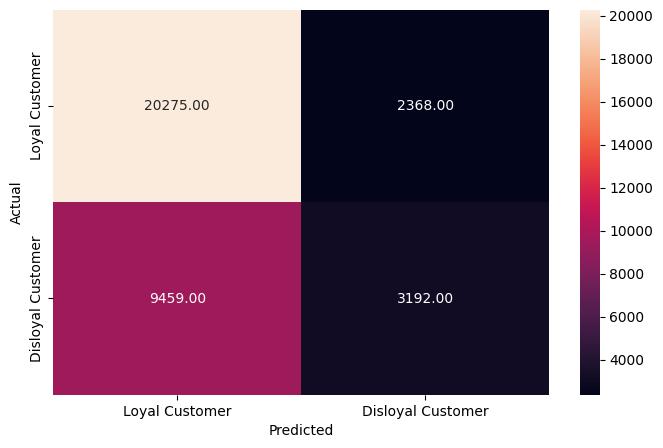

In [ ]:
# Checking performance on the test data
y_pred_test_rf = rf.predict(x_test)

test_rf_acc = metrics_score(y_test, y_pred_test_rf, target_column)

              precision    recall  f1-score   support

          -1   0.000000  0.000000  0.000000      8951
           0   0.878194  0.980536  0.926548     69823
           1   0.828735  0.871964  0.849800     15605

    accuracy                       0.869590     94379
   macro avg   0.568976  0.617500  0.592116     94379
weighted avg   0.786727  0.869590  0.825983     94379



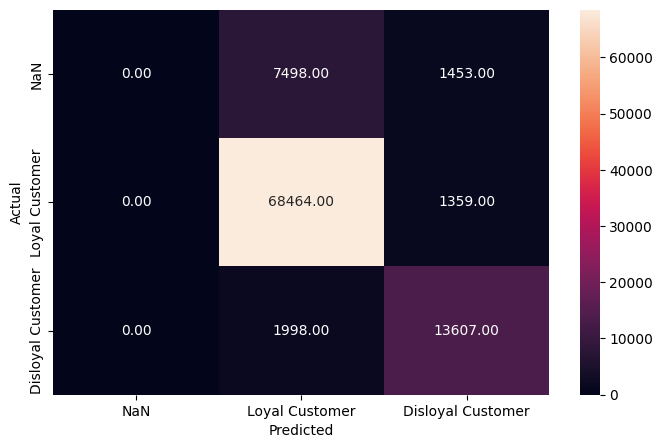

In [ ]:
# Checking performance on the all data
x_final_test = final_all[columns]
y_final_test = final_all[target_column]

y_pred_test_rf = rf.predict(x_final_test)

all_rf_acc = metrics_score(y_final_test, y_pred_test_rf, target_column)

In [ ]:
# Fitting the XGBoost-model
# Method 1) Use Cross-Validation on the dataset to find the best model.
X = df[columns]
y = df[target_column]

# cross-validator.
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=5)

# XGBoost Classifier
xgb_cv = XGBClassifier(
  random_state = 1,
  eval_metric = "logloss",
  tree_method = "hist",
  early_stopping_rounds = 4, # low number to avoid overfitting
)

# Pick the best from the cross validation above
xgb_cv = simple_XGB_optimation(xgb_cv, X, y, cv)

# Method 2) Use the current train/test chunks
xgb_m = XGBClassifier(random_state = 1, eval_metric = "logloss")
xgb_m = xgb_m.fit(x_train, y_train)

[0]	validation_0-logloss:0.64226
[1]	validation_0-logloss:0.63744
[2]	validation_0-logloss:0.63473
[3]	validation_0-logloss:0.63315
[4]	validation_0-logloss:0.63146
[5]	validation_0-logloss:0.63006
[6]	validation_0-logloss:0.62881
[7]	validation_0-logloss:0.62739
[8]	validation_0-logloss:0.62581
[9]	validation_0-logloss:0.62471
[10]	validation_0-logloss:0.62451
[11]	validation_0-logloss:0.62374
[12]	validation_0-logloss:0.62321
[13]	validation_0-logloss:0.62291
[14]	validation_0-logloss:0.62242
[15]	validation_0-logloss:0.62225
[16]	validation_0-logloss:0.62245
[17]	validation_0-logloss:0.62245
[18]	validation_0-logloss:0.62232
[19]	validation_0-logloss:0.62255
Model metrics:
    TRAIN (0.660):    Score = 0.687, Precision = 0.678, Recall = 0.588, Accuracy = 0.687
    TEST  (0.647):    Score = 0.677, Precision = 0.657, Recall = 0.576, Accuracy = 0.677
    
[0]	validation_0-logloss:0.64301
[1]	validation_0-logloss:0.63891
[2]	validation_0-logloss:0.63600
[3]	validation_0-logloss:0.63298


              precision    recall  f1-score   support

           0   0.688651  0.898291  0.779624     22643
           1   0.600035  0.273101  0.375360     12651

    accuracy                       0.674194     35294
   macro avg   0.644343  0.585696  0.577492     35294
weighted avg   0.656887  0.674194  0.634717     35294



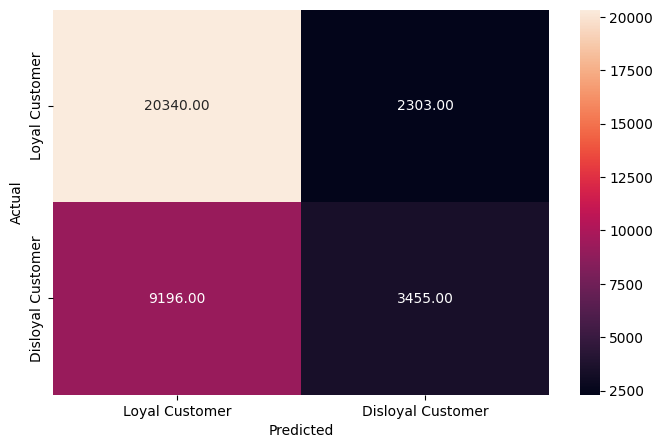

              precision    recall  f1-score   support

           0   0.691846  0.926291  0.792084     22643
           1   0.664725  0.261560  0.375404     12651

    accuracy                       0.688021     35294
   macro avg   0.678285  0.593926  0.583744     35294
weighted avg   0.682124  0.688021  0.642727     35294



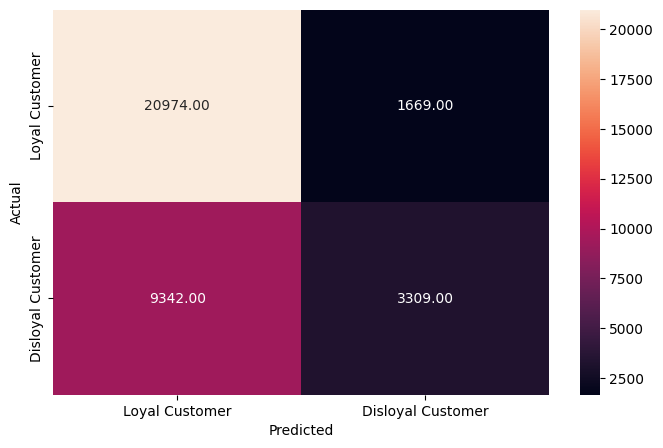

In [ ]:
# Checking performance on the test data
y_pred_test_xgb_m = xgb_m.predict(x_test)
y_pred_test_xgb_cv = xgb_cv.predict(x_test)

test_xgbm_acc = metrics_score(y_test, y_pred_test_xgb_m, target_column)
test_xgbcv_acc = metrics_score(y_test, y_pred_test_xgb_cv, target_column)

              precision    recall  f1-score   support

          -1   0.000000  0.000000  0.000000      8951
           0   0.847902  0.962720  0.901671     69823
           1   0.726177  0.702723  0.714258     15605

    accuracy                       0.828426     94379
   macro avg   0.524693  0.555148  0.538643     94379
weighted avg   0.747360  0.828426  0.785168     94379



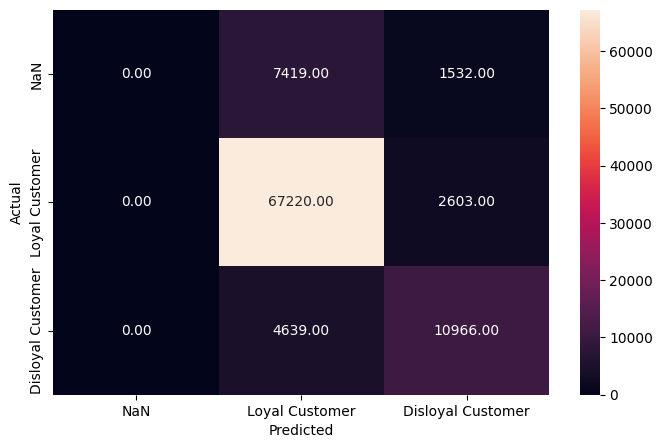

              precision    recall  f1-score   support

          -1   0.000000  0.000000  0.000000      8951
           0   0.832097  0.968477  0.895122     69823
           1   0.732611  0.615572  0.669011     15605

    accuracy                       0.818275     94379
   macro avg   0.521569  0.528016  0.521378     94379
weighted avg   0.736730  0.818275  0.772842     94379



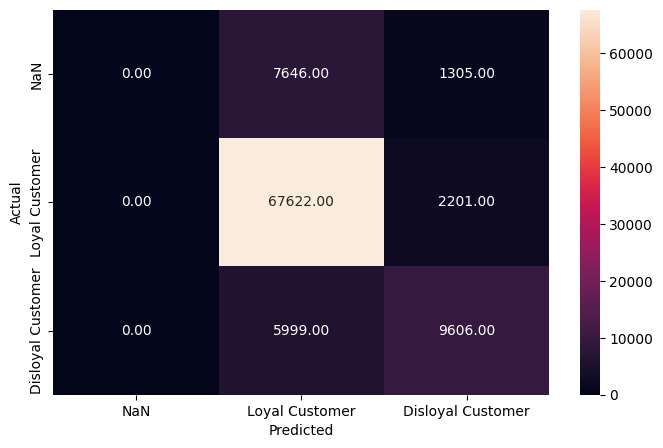

In [ ]:
# Checking performance on the all data
x_final_test = final_all[columns]
y_final_test = final_all[target_column]

y_pred_test_xgb_m = xgb_m.predict(x_final_test)
y_pred_test_xgb_cv = xgb_cv.predict(x_final_test)

all_xgbm_acc = metrics_score(y_final_test, y_pred_test_xgb_m, target_column)
all_xgbcv_acc = metrics_score(y_final_test, y_pred_test_xgb_cv, target_column)

### Update data based on models above.

In [ ]:
# Update data based on the model where missing values are.
x_final_all = final_all.loc[indices_all[target_column], columns]
x_final_test = final_test.loc[indices_test[target_column], columns]
# Which model to use? Choose the one with the best average accuacy!
x_final_model = max({
    rf: (test_rf_acc + all_rf_acc) ,
    xgb_m: (test_xgbm_acc + all_xgbm_acc),
    xgb_cv: (test_xgbcv_acc + all_xgbcv_acc)
  }.items(),
  key=lambda x: x[1]
)[0]
final_df.update(
    pd.Series(
        x_final_model.predict(x_final_all),
        name=target_column
    ).set_axis(indices_all[target_column]), # indices to update
)
final_all.update(
    pd.Series(
        x_final_model.predict(x_final_all),
        name=target_column
    ).set_axis(indices_all[target_column]), # indices to update
)
final_test.update(
    pd.Series(
        x_final_model.predict(x_final_test),
        name=target_column
    ).set_axis(indices_test[target_column]), #indices to update
)

### Type_Travel

In [ ]:
target_column = 'Type_Travel'
columns = base_columns.copy()

# Why not use the whole dataset = final_test + final_df. ID is unique across both dataframes.
df = pd.concat(
    [
        final_df[[*columns, target_column]].dropna(),
        final_test[[*columns, target_column]].dropna()
    ]
)
final_df[target_column].value_counts(),merged_df[target_column].value_counts()

(Type_Travel
  1    58617
  0    26536
 -1     9226
 Name: count, dtype: int64,
 Type_Travel
 Business Travel    58617
 Personal Travel    26536
 Name: count, dtype: int64)

In [ ]:
df = df.query(target_column + ' in (0,1)')
df

Travel_Distance  Departure_Delay_in_Mins  Arrival_Delay_in_Mins  \
ID                                                                          
98800002             2200                      9.0                    0.0   
98800003             1061                     77.0                  119.0   
98800004              780                     13.0                   18.0   
98800005             1981                      0.0                    0.0   
98800006             2810                      0.0                    0.0   
...                   ...                      ...                    ...   
99935598             1334                      0.0                    0.0   
99935599             1772                      0.0                    0.0   
99935600             1180                      0.0                    0.0   
99935601              420                     23.0                   16.0   
99935602             1680                      0.0                    0.0   

          Gender_Female  Gender_Male  Age_0-13  Age_13-25  Age_25-40  \
ID                                                                     
98800002              0            1         0          0          0   
98800003              1            0         0          0          0   
98800004              1            0         0          0          0   
98800005              1            0         0          0          0   
98800006              0            1         0          0          0   
...                 ...          ...       ...        ...        ...   
99935598              0            1         1          0          0   
99935599              1            0         0          0          0   
99935600              0            1         0          1          0   
99935601              1            0         0          0          0   
99935602              0            1         0          1          0   

          Age_40-65  Age_65+  ...  Cleanliness_Good  \
ID                            ...                     
98800002          1        0  ...                 1   
98800003          1        0  ...                 0   
98800004          1        0  ...                 0   
98800005          1        0  ...                 1   
98800006          1        0  ...                 0   
...             ...      ...  ...               ...   
99935598          0        0  ...                 1   
99935599          1        0  ...                 1   
99935600          0        0  ...                 0   
99935601          0        1  ...                 0   
99935602          0        0  ...                 1   

          Cleanliness_Needs_Improvement  Cleanliness_Poor  \
ID                                                          
98800002                              0                 0   
98800003                              0                 0   
98800004                              0                 0   
98800005                              0                 0   
98800006                              0                 0   
...                                 ...               ...   
99935598                              0                 0   
99935599                              0                 0   
99935600                              0                 0   
99935601                              0                 0   
99935602                              0                 0   

          Online_Boarding_Acceptable  Online_Boarding_Excellent  \
ID                                                                
98800002                           0                          0   
98800003                           0                          1   
98800004                           1                          0   
98800005                           0                          0   
98800006                           1                          0   
...                              ...                        ...   
99935598                 

In [ ]:
# Create train and test datasets
pcnt = .7

# Random state is a seed value
train = df.sample(frac = pcnt, random_state = 14) # I like this random_state number !
test = df.drop(train.index)

x_train = train[columns]
x_test = test[columns]

y_train = train[target_column]
y_test = test[target_column]

np.random.seed(0)

In [ ]:
rf = RandomForestClassifier(random_state = 1, criterion = 'entropy', class_weight = 'balanced')
rf = rf.fit(x_train, y_train)

              precision    recall  f1-score   support

           0   0.610604  0.461276  0.525538     14655
           1   0.672692  0.790086  0.726678     20537

    accuracy                       0.653160     35192
   macro avg   0.641648  0.625681  0.626108     35192
weighted avg   0.646837  0.653160  0.642918     35192



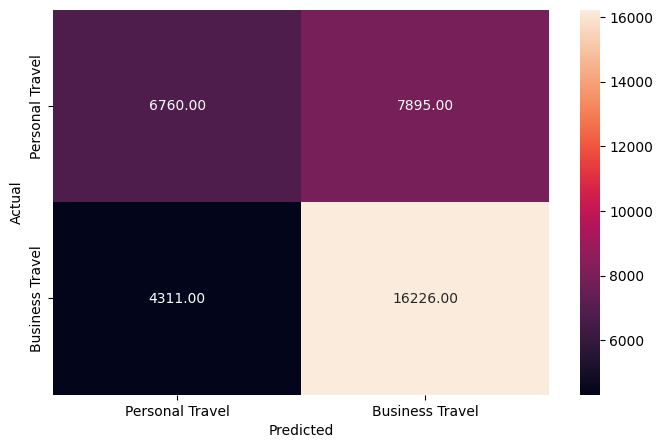

In [ ]:
# Checking performance on the test data
y_pred_test_rf = rf.predict(x_test)

test_rf_acc = metrics_score(y_test, y_pred_test_rf, target_column)

              precision    recall  f1-score   support

          -1   0.000000  0.000000  0.000000      9226
           0   0.833023  0.927985  0.877944     26536
           1   0.872505  0.964805  0.916337     58617

    accuracy                       0.860138     94379
   macro avg   0.568509  0.630930  0.598093     94379
weighted avg   0.776112  0.860138  0.815966     94379



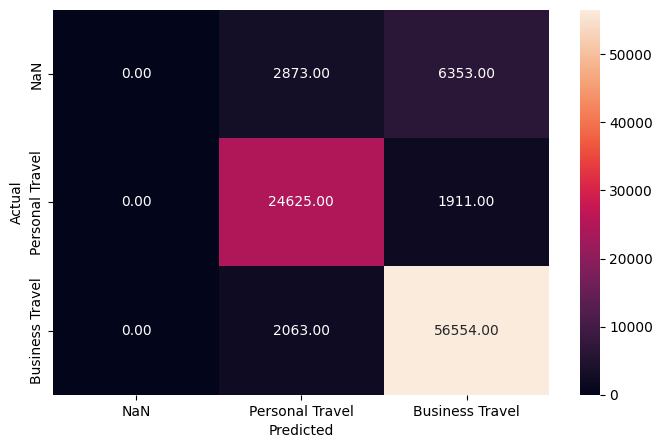

In [ ]:
# Checking performance on the all data
x_final_test = final_all[columns]
y_final_test = final_all[target_column]

y_pred_test_rf = rf.predict(x_final_test)

all_rf_acc = metrics_score(y_final_test, y_pred_test_rf, target_column)

In [ ]:
# Fitting the XGBoost-model
# Method 1) Use Cross-Validation on the dataset to find the best model.
X = df[columns]
y = df[target_column]

# cross-validator.
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=5)

# XGBoost Classifier
xgb_cv = XGBClassifier(
  random_state = 1,
  eval_metric = "logloss",
  tree_method = "hist",
  early_stopping_rounds = 4, # low number to avoid overfitting
)

# Pick the best from the cross validation above
xgb_cv = simple_XGB_optimation(xgb_cv, X, y, cv)

# Method 2) Use the current train/test chunks
xgb_m = XGBClassifier(random_state = 1, eval_metric = "logloss")
xgb_m = xgb_m.fit(x_train, y_train)

[0]	validation_0-logloss:0.65966
[1]	validation_0-logloss:0.64956
[2]	validation_0-logloss:0.64362
[3]	validation_0-logloss:0.64081
[4]	validation_0-logloss:0.63904
[5]	validation_0-logloss:0.63634
[6]	validation_0-logloss:0.63450
[7]	validation_0-logloss:0.63394
[8]	validation_0-logloss:0.63366
[9]	validation_0-logloss:0.63366
[10]	validation_0-logloss:0.63321
[11]	validation_0-logloss:0.63286
[12]	validation_0-logloss:0.63290
[13]	validation_0-logloss:0.63254
[14]	validation_0-logloss:0.63215
[15]	validation_0-logloss:0.63228
[16]	validation_0-logloss:0.63184
[17]	validation_0-logloss:0.63191
[18]	validation_0-logloss:0.63201
[19]	validation_0-logloss:0.63205
Model metrics:
    TRAIN (0.670):    Score = 0.678, Precision = 0.673, Recall = 0.649, Accuracy = 0.678
    TEST  (0.651):    Score = 0.661, Precision = 0.652, Recall = 0.631, Accuracy = 0.661
    
[0]	validation_0-logloss:0.66008
[1]	validation_0-logloss:0.64985
[2]	validation_0-logloss:0.64458
[3]	validation_0-logloss:0.64004


              precision    recall  f1-score   support

           0   0.636601  0.466189  0.538228     14655
           1   0.680172  0.810099  0.739472     20537

    accuracy                       0.666885     35192
   macro avg   0.658386  0.638144  0.638850     35192
weighted avg   0.662027  0.666885  0.655668     35192



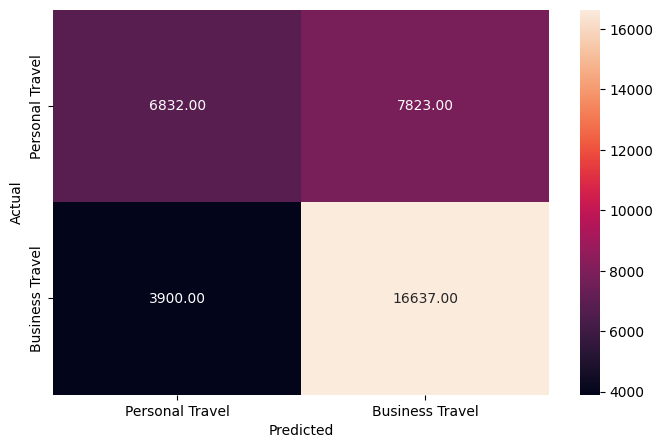

              precision    recall  f1-score   support

           0   0.664672  0.462436  0.545411     14655
           1   0.684830  0.833520  0.751894     20537

    accuracy                       0.678990     35192
   macro avg   0.674751  0.647978  0.648652     35192
weighted avg   0.676436  0.678990  0.665908     35192



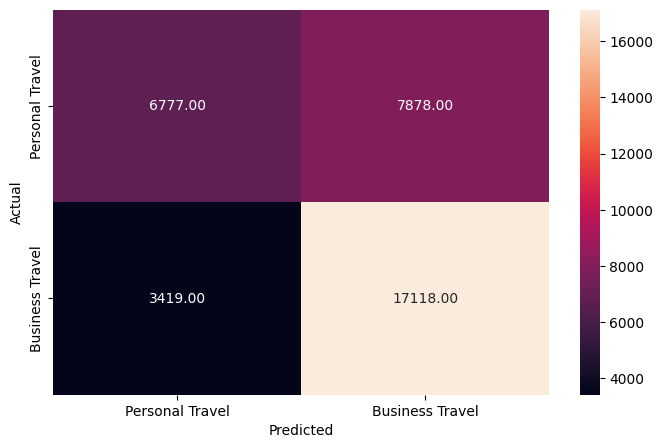

In [ ]:
# Checking performance on the test data
y_pred_test_xgb_m = xgb_m.predict(x_test)
y_pred_test_xgb_cv = xgb_cv.predict(x_test)

test_xgbm_acc = metrics_score(y_test, y_pred_test_xgb_m, target_column)
test_xgbcv_acc = metrics_score(y_test, y_pred_test_xgb_cv, target_column)

              precision    recall  f1-score   support

          -1   0.000000  0.000000  0.000000      9226
           0   0.760066  0.819528  0.788678     26536
           1   0.830340  0.931624  0.878071     58617

    accuracy                       0.809036     94379
   macro avg   0.530135  0.583717  0.555583     94379
weighted avg   0.729412  0.809036  0.767101     94379



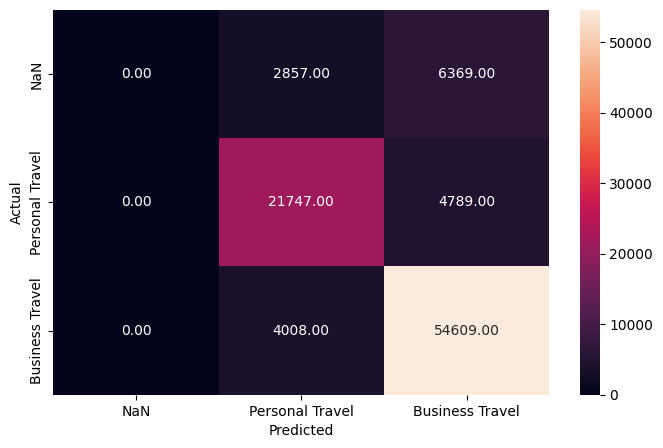

              precision    recall  f1-score   support

          -1   0.000000  0.000000  0.000000      9226
           0   0.744142  0.769521  0.756619     26536
           1   0.811064  0.926199  0.864816     58617

    accuracy                       0.791606     94379
   macro avg   0.518402  0.565240  0.540478     94379
weighted avg   0.712963  0.791606  0.749855     94379



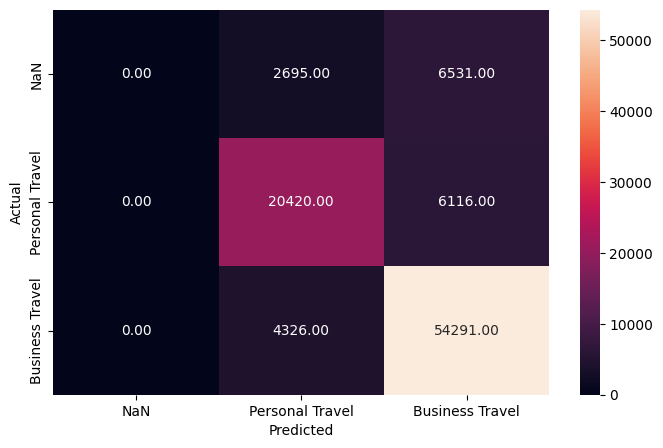

In [ ]:
# Checking performance on the all data
x_final_test = final_all[columns]
y_final_test = final_all[target_column]

y_pred_test_xgb_m = xgb_m.predict(x_final_test)
y_pred_test_xgb_cv = xgb_cv.predict(x_final_test)

all_xgbm_acc = metrics_score(y_final_test, y_pred_test_xgb_m, target_column)
all_xgbcv_acc = metrics_score(y_final_test, y_pred_test_xgb_cv, target_column)

### Update data based on models above.

In [ ]:
# Update data based on the model where missing values are.
x_final_all = final_all.loc[indices_all[target_column], columns]
x_final_test = final_test.loc[indices_test[target_column], columns]
# Which model to use? Choose the one with the best average accuacy!
x_final_model = max({
    rf: (test_rf_acc + all_rf_acc) ,
    xgb_m: (test_xgbm_acc + all_xgbm_acc),
    xgb_cv: (test_xgbcv_acc + all_xgbcv_acc)
  }.items(),
  key=lambda x: x[1]
)[0]
final_df.update(
    pd.Series(
        x_final_model.predict(x_final_all),
        name=target_column
    ).set_axis(indices_all[target_column]), # indices to update
)
final_all.update(
    pd.Series(
        x_final_model.predict(x_final_all),
        name=target_column
    ).set_axis(indices_all[target_column]), # indices to update
)
final_test.update(
    pd.Series(
        x_final_model.predict(x_final_test),
        name=target_column
    ).set_axis(indices_test[target_column]), #indices to update
)

### Arrival_Time_Convenient

In [ ]:
target_column = 'Arrival_Time_Convenient'
columns = base_columns.copy()

# Why not use the whole dataset = final_test + final_df. ID is unique across both dataframes.
df = pd.concat(
    [
        final_df[[*columns, target_column]].dropna(),
        final_test[[*columns, target_column]].dropna()
    ]
)
final_df[target_column].value_counts(),merged_df[target_column].value_counts()

(Arrival_Time_Convenient
 4.0    19574
 5.0    17684
 3.0    15177
 2.0    14990
 1.0    13692
 0.0     4332
 Name: count, dtype: int64,
 Arrival_Time_Convenient
 Good                 19574
 Excellent            17684
 Acceptable           15177
 Needs Improvement    14990
 Poor                 13692
 Extremely Poor        4332
 Name: count, dtype: int64)

In [ ]:
df

Travel_Distance  Departure_Delay_in_Mins  Arrival_Delay_in_Mins  \
ID                                                                          
98800001              272                      0.0                    5.0   
98800002             2200                      9.0                    0.0   
98800003             1061                     77.0                  119.0   
98800004              780                     13.0                   18.0   
98800005             1981                      0.0                    0.0   
...                   ...                      ...                    ...   
99935598             1334                      0.0                    0.0   
99935599             1772                      0.0                    0.0   
99935600             1180                      0.0                    0.0   
99935601              420                     23.0                   16.0   
99935602             1680                      0.0                    0.0   

          Gender_Female  Gender_Male  Age_0-13  Age_13-25  Age_25-40  \
ID                                                                     
98800001              1            0         0          0          0   
98800002              0            1         0          0          0   
98800003              1            0         0          0          0   
98800004              1            0         0          0          0   
98800005              1            0         0          0          0   
...                 ...          ...       ...        ...        ...   
99935598              0            1         1          0          0   
99935599              1            0         0          0          0   
99935600              0            1         0          1          0   
99935601              1            0         0          0          0   
99935602              0            1         0          1          0   

          Age_40-65  Age_65+  ...  Cleanliness_Good  \
ID                            ...                     
98800001          1        0  ...                 0   
98800002          1        0  ...                 1   
98800003          1        0  ...                 0   
98800004          1        0  ...                 0   
98800005          1        0  ...                 1   
...             ...      ...  ...               ...   
99935598          0        0  ...                 1   
99935599          1        0  ...                 1   
99935600          0        0  ...                 0   
99935601          0        1  ...                 0   
99935602          0        0  ...                 1   

          Cleanliness_Needs_Improvement  Cleanliness_Poor  \
ID                                                          
98800001                              1                 0   
98800002                              0                 0   
98800003                              0                 0   
98800004                              0                 0   
98800005                              0                 0   
...                                 ...               ...   
99935598                              0                 0   
99935599                              0                 0   
99935600                              0                 0   
99935601                              0                 0   
99935602                              0                 0   

          Online_Boarding_Acceptable  Online_Boarding_Excellent  \
ID                                                                
98800001                           0                          0   
98800002                           0                          0   
98800003                           0                          1   
98800004                           1                          0   
98800005                           0                          0   
...                              ...                        ...   
99935598                 

In [ ]:
# Create train and test datasets
pcnt = .7

# Random state is a seed value
train = df.sample(frac = pcnt, random_state = 14)
test = df.drop(train.index)

x_train = train[columns]
x_test = test[columns]

y_train = train[target_column]
y_test = test[target_column]

np.random.seed(0)

In [ ]:
rf = RandomForestClassifier(random_state = 1, criterion = 'entropy', class_weight = 'balanced')
rf = rf.fit(x_train, y_train)

              precision    recall  f1-score   support

         0.0   0.539142  0.432551  0.480000      1831
         1.0   0.829342  0.780756  0.804316      5633
         2.0   0.769146  0.790573  0.779712      6174
         3.0   0.742300  0.760787  0.751430      6304
         4.0   0.664725  0.718465  0.690551      8102
         5.0   0.743483  0.713638  0.728255      7274

    accuracy                       0.732743     35318
   macro avg   0.714690  0.699462  0.705711     35318
weighted avg   0.732791  0.732743  0.731998     35318



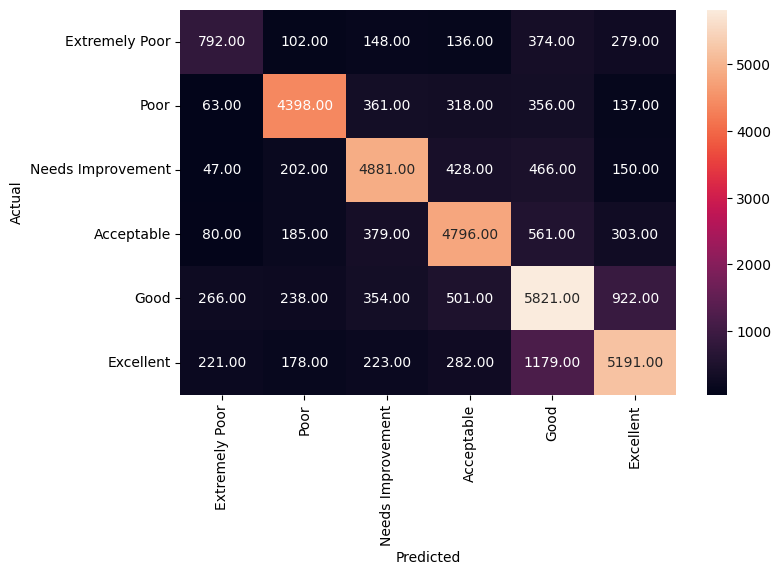

In [ ]:
# Checking performance on the test data
y_pred_test_rf = rf.predict(x_test)

test_rf_acc = metrics_score(y_test, y_pred_test_rf, target_column)

              precision    recall  f1-score   support

        -1.0   0.000000  0.000000  0.000000      8930
         0.0   0.802858  0.830102  0.816252      4332
         1.0   0.865295  0.933611  0.898156     13692
         2.0   0.840982  0.938826  0.887215     14990
         3.0   0.833491  0.928444  0.878409     15177
         4.0   0.807938  0.916164  0.858655     19574
         5.0   0.838474  0.914669  0.874915     17684

    accuracy                       0.833353     94379
   macro avg   0.712720  0.780259  0.744800     94379
weighted avg   0.754659  0.833353  0.791954     94379



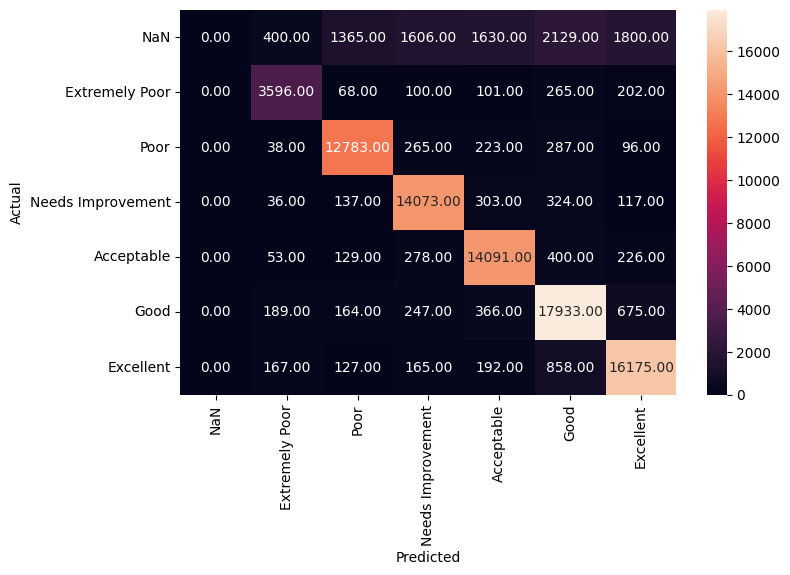

In [ ]:
# Checking performance on the all data
x_final_test = final_all[columns].fillna(-1)
y_final_test = final_all[target_column].fillna(-1)

y_pred_test_rf = rf.predict(x_final_test)

all_rf_acc = metrics_score(y_final_test, y_pred_test_rf, target_column)

In [ ]:
# Fitting the XGBoost-model
# Method 1) Use Cross-Validation on the dataset to find the best model.
X = df[columns]
y = df[target_column]

# cross-validator.
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=5)

# XGBoost Classifier
xgb_cv = XGBClassifier(
  random_state = 1,
  eval_metric = "mlogloss", # For multi-class use mlogloss
  tree_method = "hist",
  early_stopping_rounds = 4, # low number to avoid overfitting
)

# Pick the best from the cross validation above
xgb_cv = simple_XGB_optimation(xgb_cv, X, y, cv)

# Method 2) Use the current train/test chunks
xgb_m = XGBClassifier(random_state = 1, eval_metric = "mlogloss")
xgb_m = xgb_m.fit(x_train, y_train)

[0]	validation_0-mlogloss:1.38428
[1]	validation_0-mlogloss:1.19787
[2]	validation_0-mlogloss:1.08243
[3]	validation_0-mlogloss:1.00325
[4]	validation_0-mlogloss:0.94857
[5]	validation_0-mlogloss:0.90975
[6]	validation_0-mlogloss:0.88098
[7]	validation_0-mlogloss:0.85932
[8]	validation_0-mlogloss:0.84393
[9]	validation_0-mlogloss:0.83105
[10]	validation_0-mlogloss:0.82158
[11]	validation_0-mlogloss:0.81398
[12]	validation_0-mlogloss:0.80764
[13]	validation_0-mlogloss:0.80246
[14]	validation_0-mlogloss:0.79752
[15]	validation_0-mlogloss:0.79388
[16]	validation_0-mlogloss:0.79090
[17]	validation_0-mlogloss:0.78867
[18]	validation_0-mlogloss:0.78664
[19]	validation_0-mlogloss:0.78416
[20]	validation_0-mlogloss:0.78174
[21]	validation_0-mlogloss:0.78019
[22]	validation_0-mlogloss:0.77893
[23]	validation_0-mlogloss:0.77670
[24]	validation_0-mlogloss:0.77595
[25]	validation_0-mlogloss:0.77476
[26]	validation_0-mlogloss:0.77372
[27]	validation_0-mlogloss:0.77298
[28]	validation_0-mlogloss:0.7

              precision    recall  f1-score   support

         0.0   0.553012  0.501365  0.525924      1831
         1.0   0.839173  0.778093  0.807480      5633
         2.0   0.777831  0.788792  0.783273      6174
         3.0   0.746516  0.764753  0.755524      6304
         4.0   0.664388  0.719822  0.690995      8102
         5.0   0.748198  0.713638  0.730509      7274

    accuracy                       0.736593     35318
   macro avg   0.721520  0.711077  0.715618     35318
weighted avg   0.738243  0.736593  0.736803     35318



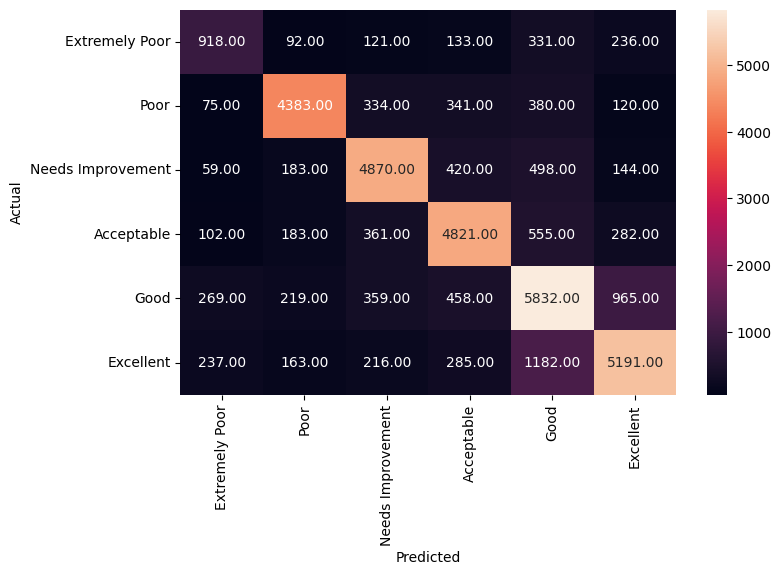

              precision    recall  f1-score   support

         0.0   0.624396  0.564719  0.593060      1831
         1.0   0.865823  0.801882  0.832627      5633
         2.0   0.806835  0.814545  0.810671      6174
         3.0   0.771895  0.795527  0.783533      6304
         4.0   0.709568  0.771661  0.739313      8102
         5.0   0.800840  0.760104  0.779941      7274

    accuracy                       0.775129     35318
   macro avg   0.763226  0.751406  0.756524     35318
weighted avg   0.777000  0.775129  0.775348     35318



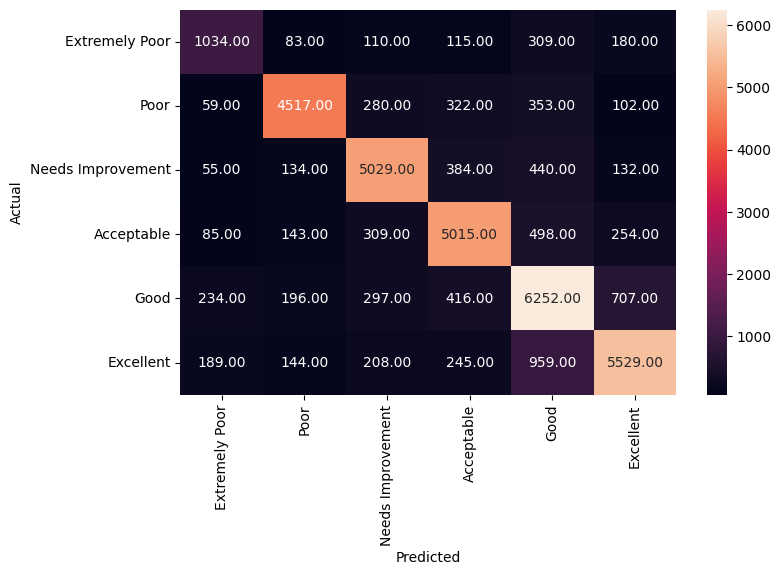

In [ ]:
# Checking performance on the test data
y_pred_test_xgb_m = xgb_m.predict(x_test)
y_pred_test_xgb_cv = xgb_cv.predict(x_test)

test_xgbm_acc = metrics_score(y_test, y_pred_test_xgb_m, target_column)
test_xgbcv_acc = metrics_score(y_test, y_pred_test_xgb_cv, target_column)

              precision    recall  f1-score   support

        -1.0   0.000000  0.000000  0.000000      8930
         0.0   0.583524  0.588643  0.586072      4332
         1.0   0.782523  0.808355  0.795229     13692
         2.0   0.740028  0.825484  0.780423     14990
         3.0   0.707890  0.802201  0.752100     15177
         4.0   0.652744  0.777664  0.709750     19574
         5.0   0.728698  0.767473  0.747583     17684

    accuracy                       0.709490     94379
   macro avg   0.599344  0.652831  0.624451     94379
weighted avg   0.643595  0.709490  0.674443     94379



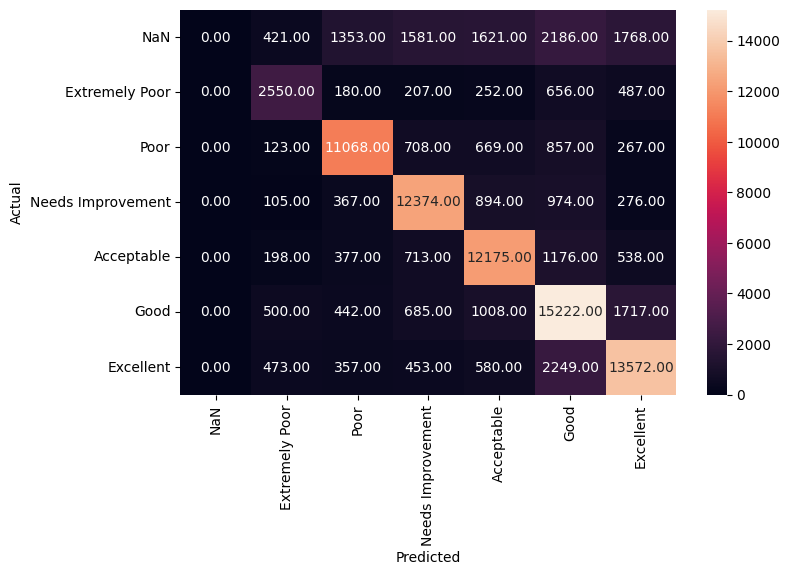

              precision    recall  f1-score   support

        -1.0   0.000000  0.000000  0.000000      8930
         0.0   0.561832  0.557941  0.559880      4332
         1.0   0.777172  0.801125  0.788966     13692
         2.0   0.735195  0.813276  0.772267     14990
         3.0   0.695560  0.795744  0.742286     15177
         4.0   0.638557  0.767906  0.697284     19574
         5.0   0.718491  0.750792  0.734286     17684

    accuracy                       0.698905     94379
   macro avg   0.589544  0.640969  0.613567     94379
weighted avg   0.634218  0.698905  0.664381     94379



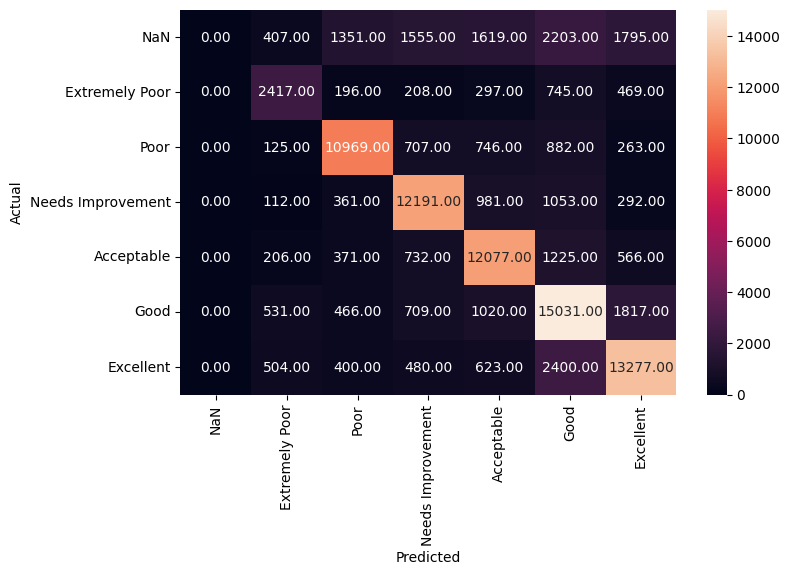

In [ ]:
# Checking performance on the all data
x_final_test = final_all[columns].fillna(-1)
y_final_test = final_all[target_column].fillna(-1)

y_pred_test_xgb_m = xgb_m.predict(x_final_test)
y_pred_test_xgb_cv = xgb_cv.predict(x_final_test)

all_xgbm_acc = metrics_score(y_final_test, y_pred_test_xgb_m, target_column)
all_xgbcv_acc = metrics_score(y_final_test, y_pred_test_xgb_cv, target_column)

### Update data based on models above.

In [ ]:
# Update data based on the model where missing values are.
x_final_all = final_all.loc[indices_all[target_column], columns]
x_final_test = final_test.loc[indices_test[target_column], columns]
# Which model to use? Choose the one with the best average accuacy!
x_final_model = max({
    rf: (test_rf_acc + all_rf_acc) ,
    xgb_m: (test_xgbm_acc + all_xgbm_acc),
    xgb_cv: (test_xgbcv_acc + all_xgbcv_acc)
  }.items(),
  key=lambda x: x[1]
)[0]
final_df.update(
    pd.Series(
        x_final_model.predict(x_final_all),
        name=target_column
    ).set_axis(indices_all[target_column]), # indices to update
)
final_all.update(
    pd.Series(
        x_final_model.predict(x_final_all),
        name=target_column
    ).set_axis(indices_all[target_column]), # indices to update
)
final_test.update(
    pd.Series(
        x_final_model.predict(x_final_test),
        name=target_column
    ).set_axis(indices_test[target_column]), #indices to update
)

### Catering

In [ ]:
target_column = 'Catering'
columns = base_columns.copy()

# Why not use the whole dataset = final_test + final_df. ID is unique across both dataframes.
df = pd.concat(
    [
        final_df[[*columns, target_column]].dropna(),
        final_test[[*columns, target_column]].dropna()
    ]
)
final_df[target_column].value_counts(),merged_df[target_column].value_counts()

(Catering
 3.0    18468
 2.0    17978
 4.0    17969
 1.0    13858
 5.0    13455
 0.0     3910
 Name: count, dtype: int64,
 Catering
 Acceptable           18468
 Needs Improvement    17978
 Good                 17969
 Poor                 13858
 Excellent            13455
 Extremely Poor        3910
 Name: count, dtype: int64)

In [ ]:
df

Travel_Distance  Departure_Delay_in_Mins  Arrival_Delay_in_Mins  \
ID                                                                          
98800001              272                      0.0                    5.0   
98800002             2200                      9.0                    0.0   
98800003             1061                     77.0                  119.0   
98800005             1981                      0.0                    0.0   
98800006             2810                      0.0                    0.0   
...                   ...                      ...                    ...   
99935598             1334                      0.0                    0.0   
99935599             1772                      0.0                    0.0   
99935600             1180                      0.0                    0.0   
99935601              420                     23.0                   16.0   
99935602             1680                      0.0                    0.0   

          Gender_Female  Gender_Male  Age_0-13  Age_13-25  Age_25-40  \
ID                                                                     
98800001              1            0         0          0          0   
98800002              0            1         0          0          0   
98800003              1            0         0          0          0   
98800005              1            0         0          0          0   
98800006              0            1         0          0          0   
...                 ...          ...       ...        ...        ...   
99935598              0            1         1          0          0   
99935599              1            0         0          0          0   
99935600              0            1         0          1          0   
99935601              1            0         0          0          0   
99935602              0            1         0          1          0   

          Age_40-65  Age_65+  ...  Cleanliness_Good  \
ID                            ...                     
98800001          1        0  ...                 0   
98800002          1        0  ...                 1   
98800003          1        0  ...                 0   
98800005          1        0  ...                 1   
98800006          1        0  ...                 0   
...             ...      ...  ...               ...   
99935598          0        0  ...                 1   
99935599          1        0  ...                 1   
99935600          0        0  ...                 0   
99935601          0        1  ...                 0   
99935602          0        0  ...                 1   

          Cleanliness_Needs_Improvement  Cleanliness_Poor  \
ID                                                          
98800001                              1                 0   
98800002                              0                 0   
98800003                              0                 0   
98800005                              0                 0   
98800006                              0                 0   
...                                 ...               ...   
99935598                              0                 0   
99935599                              0                 0   
99935600                              0                 0   
99935601                              0                 0   
99935602                              0                 0   

          Online_Boarding_Acceptable  Online_Boarding_Excellent  \
ID                                                                
98800001                           0                          0   
98800002                           0                          0   
98800003                           0                          1   
98800005                           0                          0   
98800006                           1                          0   
...                              ...                        ...   
99935598                 

In [ ]:
# Create train and test datasets
pcnt = .7

# Random state is a seed value
train = df.sample(frac = pcnt, random_state = 14)
test = df.drop(train.index)

x_train = train[columns]
x_test = test[columns]

y_train = train[target_column]
y_test = test[target_column]

np.random.seed(0)

In [ ]:
rf = RandomForestClassifier(random_state = 1, criterion = 'entropy', class_weight = 'balanced')
rf = rf.fit(x_train, y_train)

              precision    recall  f1-score   support

         0.0   0.956783  0.967233  0.961979      1648
         1.0   0.853396  0.903120  0.877554      5801
         2.0   0.875067  0.886798  0.880893      7385
         3.0   0.882893  0.859018  0.870792      7618
         4.0   0.871327  0.848943  0.859989      7474
         5.0   0.863805  0.854753  0.859255      5439

    accuracy                       0.874311     35365
   macro avg   0.883878  0.886644  0.885077     35365
weighted avg   0.874483  0.874311  0.874202     35365



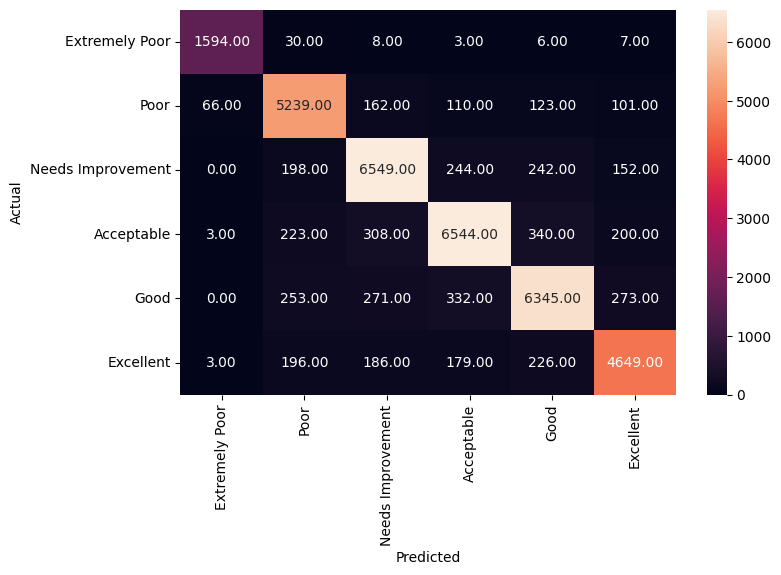

In [ ]:
# Checking performance on the test data
y_pred_test_rf = rf.predict(x_test)

test_rf_acc = metrics_score(y_test, y_pred_test_rf, target_column)

              precision    recall  f1-score   support

        -1.0   0.000000  0.000000  0.000000      8741
         0.0   0.893681  0.991049  0.939850      3910
         1.0   0.860413  0.970991  0.912364     13858
         2.0   0.873710  0.965124  0.917145     17978
         3.0   0.875985  0.957332  0.914853     18468
         4.0   0.874211  0.955701  0.913142     17969
         5.0   0.875459  0.957637  0.914706     13455

    accuracy                       0.873287     94379
   macro avg   0.750494  0.828262  0.787437     94379
weighted avg   0.792455  0.873287  0.830883     94379



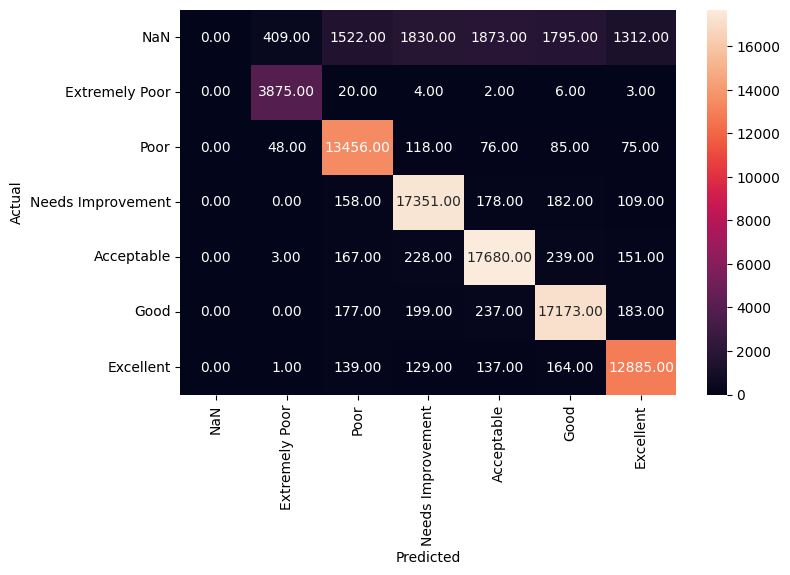

In [ ]:
# Checking performance on the all data
x_final_test = final_all[columns].fillna(-1)
y_final_test = final_all[target_column].fillna(-1)

y_pred_test_rf = rf.predict(x_final_test)

all_rf_acc = metrics_score(y_final_test, y_pred_test_rf, target_column)

In [ ]:
# Fitting the XGBoost-model
# Method 1) Use Cross-Validation on the dataset to find the best model.
X = df[columns]
y = df[target_column]

# cross-validator.
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=5)

# XGBoost Classifier
xgb_cv = XGBClassifier(
  random_state = 1,
  eval_metric = "mlogloss", # For multi-class use mlogloss
  tree_method = "hist",
  early_stopping_rounds = 4, # low number to avoid overfitting
)

# Pick the best from the cross validation above
xgb_cv = simple_XGB_optimation(xgb_cv, X, y, cv)

# Method 2) Use the current train/test chunks
xgb_m = XGBClassifier(random_state = 1, eval_metric = "mlogloss")
xgb_m = xgb_m.fit(x_train, y_train)

[0]	validation_0-mlogloss:1.25267
[1]	validation_0-mlogloss:1.00805
[2]	validation_0-mlogloss:0.85419
[3]	validation_0-mlogloss:0.75054
[4]	validation_0-mlogloss:0.67861
[5]	validation_0-mlogloss:0.62735
[6]	validation_0-mlogloss:0.59015
[7]	validation_0-mlogloss:0.56305
[8]	validation_0-mlogloss:0.54313
[9]	validation_0-mlogloss:0.52783
[10]	validation_0-mlogloss:0.51599
[11]	validation_0-mlogloss:0.50634
[12]	validation_0-mlogloss:0.49871
[13]	validation_0-mlogloss:0.49278
[14]	validation_0-mlogloss:0.48805
[15]	validation_0-mlogloss:0.48430
[16]	validation_0-mlogloss:0.48135
[17]	validation_0-mlogloss:0.47913
[18]	validation_0-mlogloss:0.47719
[19]	validation_0-mlogloss:0.47546
[20]	validation_0-mlogloss:0.47397
[21]	validation_0-mlogloss:0.47295
[22]	validation_0-mlogloss:0.47171
[23]	validation_0-mlogloss:0.47101
[24]	validation_0-mlogloss:0.47008
[25]	validation_0-mlogloss:0.46907
[26]	validation_0-mlogloss:0.46848
[27]	validation_0-mlogloss:0.46781
[28]	validation_0-mlogloss:0.4

              precision    recall  f1-score   support

         0.0   0.961171  0.976335  0.968694      1648
         1.0   0.863427  0.906740  0.884554      5801
         2.0   0.880194  0.883412  0.881800      7385
         3.0   0.878857  0.863744  0.871235      7618
         4.0   0.867755  0.853358  0.860496      7474
         5.0   0.867103  0.852914  0.859950      5439

    accuracy                       0.876290     35365
   macro avg   0.886418  0.889417  0.887788     35365
weighted avg   0.876287  0.876290  0.876162     35365



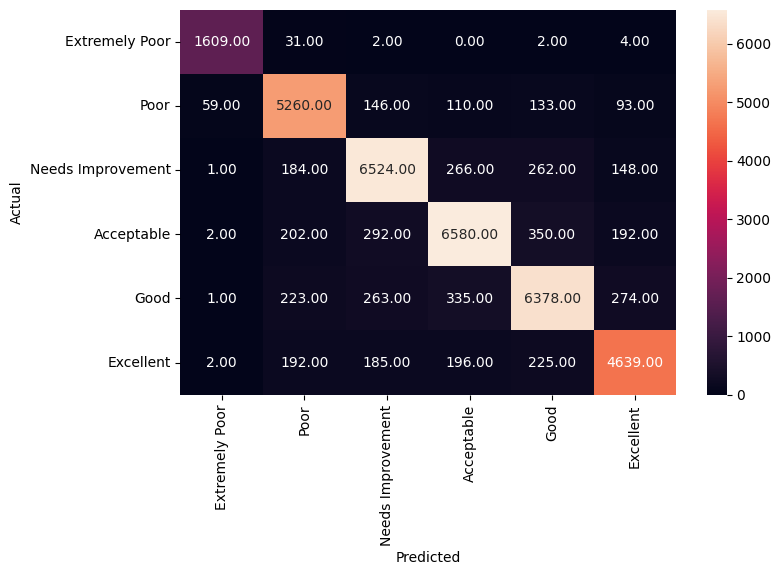

              precision    recall  f1-score   support

         0.0   0.969388  0.979976  0.974653      1648
         1.0   0.871475  0.916394  0.893370      5801
         2.0   0.889970  0.891537  0.890753      7385
         3.0   0.887978  0.881334  0.884643      7618
         4.0   0.883199  0.862992  0.872978      7474
         5.0   0.875586  0.859165  0.867298      5439

    accuracy                       0.886526     35365
   macro avg   0.896266  0.898566  0.897283     35365
weighted avg   0.886565  0.886526  0.886412     35365



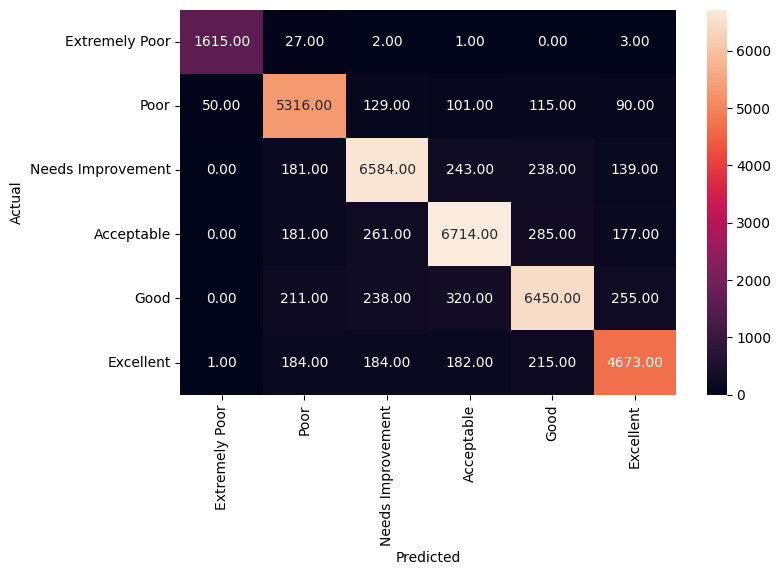

In [ ]:
# Checking performance on the test data
y_pred_test_xgb_m = xgb_m.predict(x_test)
y_pred_test_xgb_cv = xgb_cv.predict(x_test)

test_xgbm_acc = metrics_score(y_test, y_pred_test_xgb_m, target_column)
test_xgbcv_acc = metrics_score(y_test, y_pred_test_xgb_cv, target_column)

              precision    recall  f1-score   support

        -1.0   0.000000  0.000000  0.000000      8741
         0.0   0.886619  0.987980  0.934559      3910
         1.0   0.794447  0.922860  0.853852     13858
         2.0   0.813482  0.898098  0.853699     17978
         3.0   0.808663  0.881525  0.843523     18468
         4.0   0.801908  0.870054  0.834592     17969
         5.0   0.802187  0.861390  0.830735     13455

    accuracy                       0.808464     94379
   macro avg   0.701044  0.774558  0.735852     94379
weighted avg   0.733619  0.808464  0.769102     94379



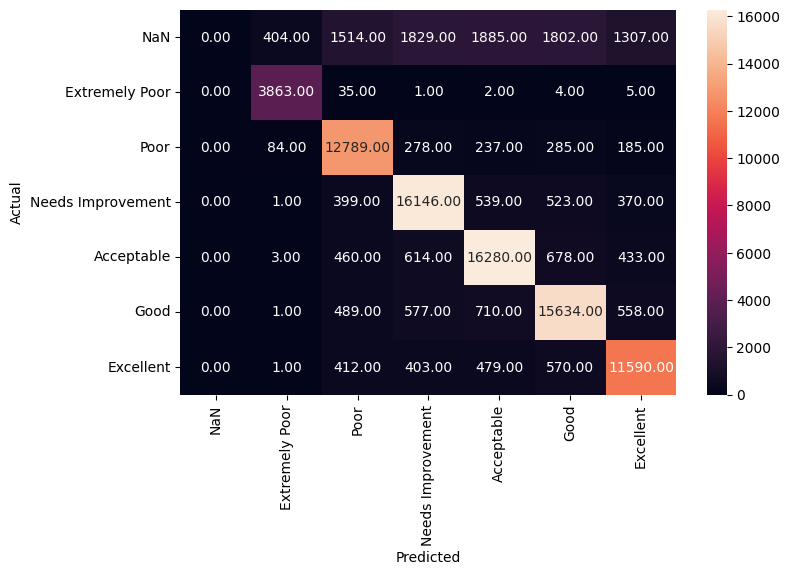

              precision    recall  f1-score   support

        -1.0   0.000000  0.000000  0.000000      8741
         0.0   0.881679  0.983376  0.929755      3910
         1.0   0.786897  0.915284  0.846249     13858
         2.0   0.806986  0.891868  0.847306     17978
         3.0   0.800999  0.877031  0.837292     18468
         4.0   0.798205  0.861150  0.828483     17969
         5.0   0.796644  0.853958  0.824306     13455

    accuracy                       0.802340     94379
   macro avg   0.695916  0.768952  0.730484     94379
weighted avg   0.728073  0.802340  0.763270     94379



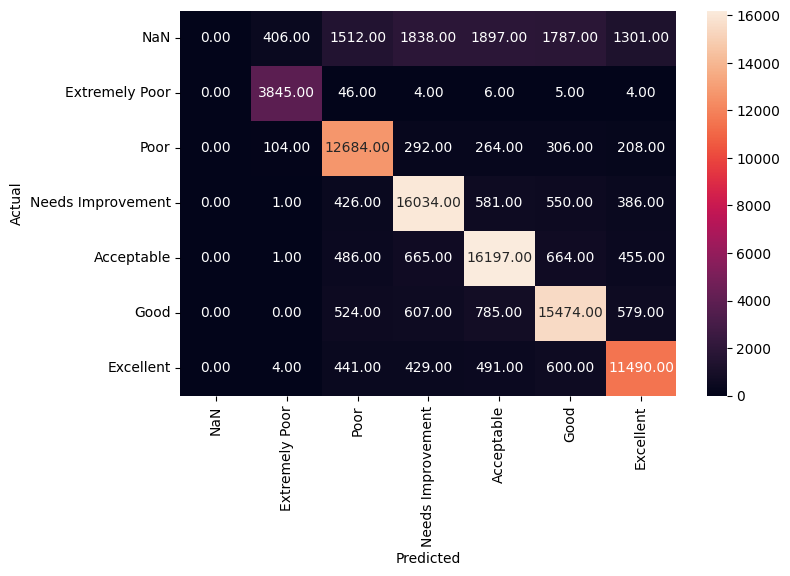

In [ ]:
# Checking performance on the all data
x_final_test = final_all[columns].fillna(-1)
y_final_test = final_all[target_column].fillna(-1)

y_pred_test_xgb_m = xgb_m.predict(x_final_test)
y_pred_test_xgb_cv = xgb_cv.predict(x_final_test)

all_xgbm_acc = metrics_score(y_final_test, y_pred_test_xgb_m, target_column)
all_xgbcv_acc = metrics_score(y_final_test, y_pred_test_xgb_cv, target_column)

### Update data based on models above.

In [ ]:
# Update data based on the model where missing values are.
x_final_all = final_all.loc[indices_all[target_column], columns]
x_final_test = final_test.loc[indices_test[target_column], columns]
# Which model to use? Choose the one with the best average accuacy!
x_final_model = max({
    rf: (test_rf_acc + all_rf_acc) ,
    xgb_m: (test_xgbm_acc + all_xgbm_acc),
    xgb_cv: (test_xgbcv_acc + all_xgbcv_acc)
  }.items(),
  key=lambda x: x[1]
)[0]
final_df.update(
    pd.Series(
        x_final_model.predict(x_final_all),
        name=target_column
    ).set_axis(indices_all[target_column]), # indices to update
)
final_all.update(
    pd.Series(
        x_final_model.predict(x_final_all),
        name=target_column
    ).set_axis(indices_all[target_column]), # indices to update
)
final_test.update(
    pd.Series(
        x_final_model.predict(x_final_test),
        name=target_column
    ).set_axis(indices_test[target_column]), #indices to update
)

### Onboard_Service

In [ ]:
target_column = 'Onboard_Service'
columns = base_columns.copy()

# Why not use the whole dataset = final_test + final_df. ID is unique across both dataframes.
df = pd.concat(
    [
        final_df[[*columns, target_column]].dropna(),
        final_test[[*columns, target_column]].dropna()
    ]
)
final_df[target_column].value_counts(),merged_df[target_column].value_counts()

(Onboard_Service
 4.0    27265
 5.0    21272
 3.0    18071
 2.0    11390
 1.0     8776
 0.0        4
 Name: count, dtype: int64,
 Onboard_Service
 Good                 27265
 Excellent            21272
 Acceptable           18071
 Needs Improvement    11390
 Poor                  8776
 Extremely Poor           4
 Name: count, dtype: int64)

In [ ]:
df

Travel_Distance  Departure_Delay_in_Mins  Arrival_Delay_in_Mins  \
ID                                                                          
98800001              272                      0.0                    5.0   
98800002             2200                      9.0                    0.0   
98800003             1061                     77.0                  119.0   
98800004              780                     13.0                   18.0   
98800005             1981                      0.0                    0.0   
...                   ...                      ...                    ...   
99935598             1334                      0.0                    0.0   
99935599             1772                      0.0                    0.0   
99935600             1180                      0.0                    0.0   
99935601              420                     23.0                   16.0   
99935602             1680                      0.0                    0.0   

          Gender_Female  Gender_Male  Age_0-13  Age_13-25  Age_25-40  \
ID                                                                     
98800001              1            0         0          0          0   
98800002              0            1         0          0          0   
98800003              1            0         0          0          0   
98800004              1            0         0          0          0   
98800005              1            0         0          0          0   
...                 ...          ...       ...        ...        ...   
99935598              0            1         1          0          0   
99935599              1            0         0          0          0   
99935600              0            1         0          1          0   
99935601              1            0         0          0          0   
99935602              0            1         0          1          0   

          Age_40-65  Age_65+  ...  Cleanliness_Good  \
ID                            ...                     
98800001          1        0  ...                 0   
98800002          1        0  ...                 1   
98800003          1        0  ...                 0   
98800004          1        0  ...                 0   
98800005          1        0  ...                 1   
...             ...      ...  ...               ...   
99935598          0        0  ...                 1   
99935599          1        0  ...                 1   
99935600          0        0  ...                 0   
99935601          0        1  ...                 0   
99935602          0        0  ...                 1   

          Cleanliness_Needs_Improvement  Cleanliness_Poor  \
ID                                                          
98800001                              1                 0   
98800002                              0                 0   
98800003                              0                 0   
98800004                              0                 0   
98800005                              0                 0   
...                                 ...               ...   
99935598                              0                 0   
99935599                              0                 0   
99935600                              0                 0   
99935601                              0                 0   
99935602                              0                 0   

          Online_Boarding_Acceptable  Online_Boarding_Excellent  \
ID                                                                
98800001                           0                          0   
98800002                           0                          0   
98800003                           0                          1   
98800004                           1                          0   
98800005                           0                          0   
...                              ...                        ...   
99935598                 

In [ ]:
# Create train and test datasets
pcnt = .7

# Random state is a seed value
train = df.sample(frac = pcnt, random_state = 14)
test = df.drop(train.index)

x_train = train[columns]
x_test = test[columns]

y_train = train[target_column]
y_test = test[target_column]

np.random.seed(0)

In [ ]:
rf = RandomForestClassifier(random_state = 1, criterion = 'entropy', class_weight = 'balanced')
rf = rf.fit(x_train, y_train)

              precision    recall  f1-score   support

         0.0   1.000000  1.000000  1.000000         1
         1.0   0.419336  0.398847  0.408835      3643
         2.0   0.549273  0.493674  0.519991      4742
         3.0   0.469645  0.505982  0.487137      7522
         4.0   0.628724  0.672757  0.649996     11166
         5.0   0.735505  0.676350  0.704688      8778

    accuracy                       0.587136     35852
   macro avg   0.633747  0.624602  0.628441     35852
weighted avg   0.589718  0.587136  0.587527     35852



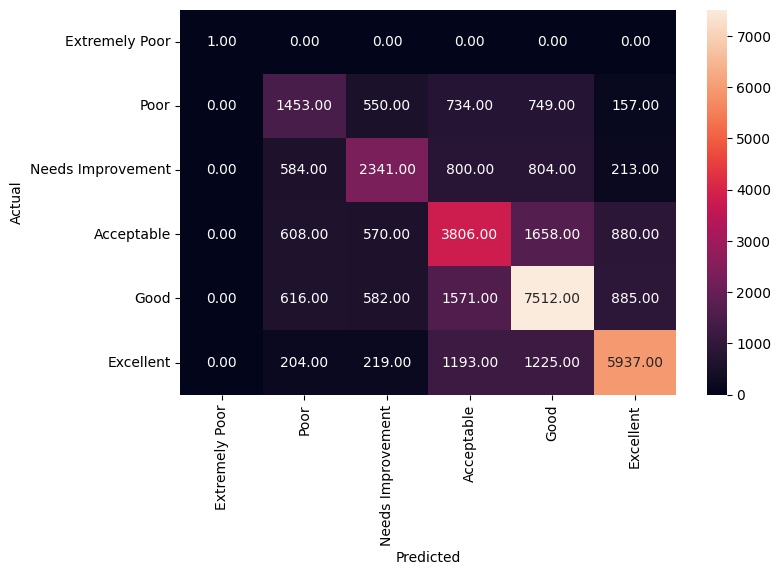

In [ ]:
# Checking performance on the test data
y_pred_test_rf = rf.predict(x_test)

test_rf_acc = metrics_score(y_test, y_pred_test_rf, target_column)

              precision    recall  f1-score   support

        -1.0   0.000000  0.000000  0.000000      7601
         0.0   0.800000  1.000000  0.888889         4
         1.0   0.763939  0.821217  0.791543      8776
         2.0   0.807175  0.847498  0.826845     11390
         3.0   0.760795  0.851143  0.803437     18071
         4.0   0.810880  0.900458  0.853325     27265
         5.0   0.854449  0.903253  0.878174     21272

    accuracy                       0.805370     94379
   macro avg   0.685320  0.760510  0.720316     94379
weighted avg   0.740992  0.805370  0.771710     94379



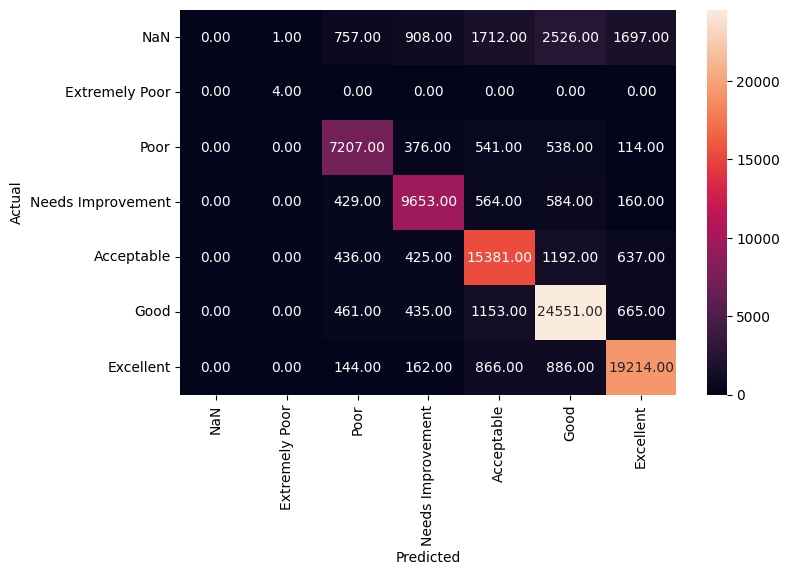

In [ ]:
# Checking performance on the all data
x_final_test = final_all[columns].fillna(-1)
y_final_test = final_all[target_column].fillna(-1)

y_pred_test_rf = rf.predict(x_final_test)

all_rf_acc = metrics_score(y_final_test, y_pred_test_rf, target_column)

In [ ]:
# Fitting the XGBoost-model
# Method 1) Use Cross-Validation on the dataset to find the best model.
X = df[columns]
y = df[target_column]

# cross-validator.
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=5)

# XGBoost Classifier
xgb_cv = XGBClassifier(
  random_state = 1,
  eval_metric = "mlogloss", # For multi-class use mlogloss
  tree_method = "hist",
  early_stopping_rounds = 4, # low number to avoid overfitting
)

# Pick the best from the cross validation above
xgb_cv = simple_XGB_optimation(xgb_cv, X, y, cv)

# Method 2) Use the current train/test chunks
xgb_m = XGBClassifier(random_state = 1, eval_metric = "mlogloss")
xgb_m = xgb_m.fit(x_train, y_train)

[0]	validation_0-mlogloss:1.42385
[1]	validation_0-mlogloss:1.26098
[2]	validation_0-mlogloss:1.15715
[3]	validation_0-mlogloss:1.08459
[4]	validation_0-mlogloss:1.03185
[5]	validation_0-mlogloss:0.99190
[6]	validation_0-mlogloss:0.96091
[7]	validation_0-mlogloss:0.93680
[8]	validation_0-mlogloss:0.91842
[9]	validation_0-mlogloss:0.90315
[10]	validation_0-mlogloss:0.89152
[11]	validation_0-mlogloss:0.88209
[12]	validation_0-mlogloss:0.87491
[13]	validation_0-mlogloss:0.86829
[14]	validation_0-mlogloss:0.86366
[15]	validation_0-mlogloss:0.85916
[16]	validation_0-mlogloss:0.85591
[17]	validation_0-mlogloss:0.85280
[18]	validation_0-mlogloss:0.85037
[19]	validation_0-mlogloss:0.84822
[20]	validation_0-mlogloss:0.84702
[21]	validation_0-mlogloss:0.84567
[22]	validation_0-mlogloss:0.84478
[23]	validation_0-mlogloss:0.84364
[24]	validation_0-mlogloss:0.84297
[25]	validation_0-mlogloss:0.84230
[26]	validation_0-mlogloss:0.84188
[27]	validation_0-mlogloss:0.84130
[28]	validation_0-mlogloss:0.8

              precision    recall  f1-score   support

         0.0   1.000000  1.000000  1.000000         1
         1.0   0.408528  0.407631  0.408079      3643
         2.0   0.534287  0.496204  0.514542      4742
         3.0   0.466607  0.482053  0.474204      7522
         4.0   0.633590  0.662189  0.647574     11166
         5.0   0.711623  0.678628  0.694734      8778

    accuracy                       0.580609     35852
   macro avg   0.625773  0.621118  0.623189     35852
weighted avg   0.581668  0.580609  0.580825     35852



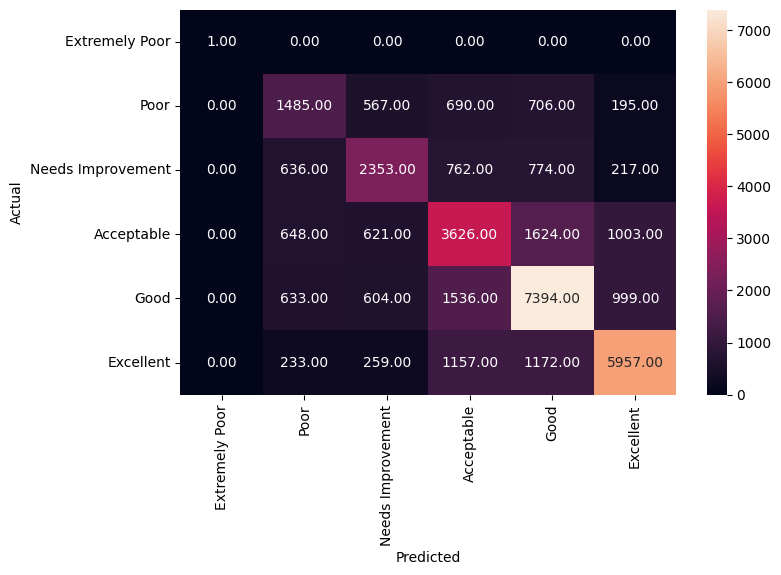

              precision    recall  f1-score   support

         0.0   1.000000  1.000000  1.000000         1
         1.0   0.525267  0.513588  0.519362      3643
         2.0   0.618559  0.584774  0.601192      4742
         3.0   0.553688  0.564876  0.559226      7522
         4.0   0.681125  0.724252  0.702027     11166
         5.0   0.775518  0.729665  0.751893      8778

    accuracy                       0.652293     35852
   macro avg   0.692359  0.686193  0.688950     35852
weighted avg   0.653395  0.652293  0.652386     35852



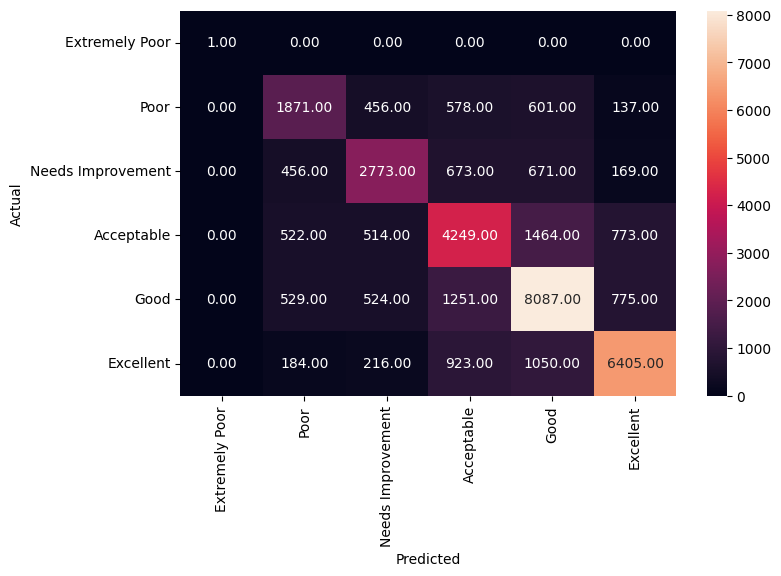

In [ ]:
# Checking performance on the test data
y_pred_test_xgb_m = xgb_m.predict(x_test)
y_pred_test_xgb_cv = xgb_cv.predict(x_test)

test_xgbm_acc = metrics_score(y_test, y_pred_test_xgb_m, target_column)
test_xgbcv_acc = metrics_score(y_test, y_pred_test_xgb_cv, target_column)

              precision    recall  f1-score   support

        -1.0   0.000000  0.000000  0.000000      7601
         0.0   0.800000  1.000000  0.888889         4
         1.0   0.537695  0.584321  0.560039      8776
         2.0   0.631247  0.649868  0.640422     11390
         3.0   0.563424  0.628742  0.594293     18071
         4.0   0.670900  0.757491  0.711571     27265
         5.0   0.736790  0.767582  0.751871     21272

    accuracy                       0.645027     94379
   macro avg   0.562865  0.626858  0.592441     94379
weighted avg   0.593974  0.645027  0.618222     94379



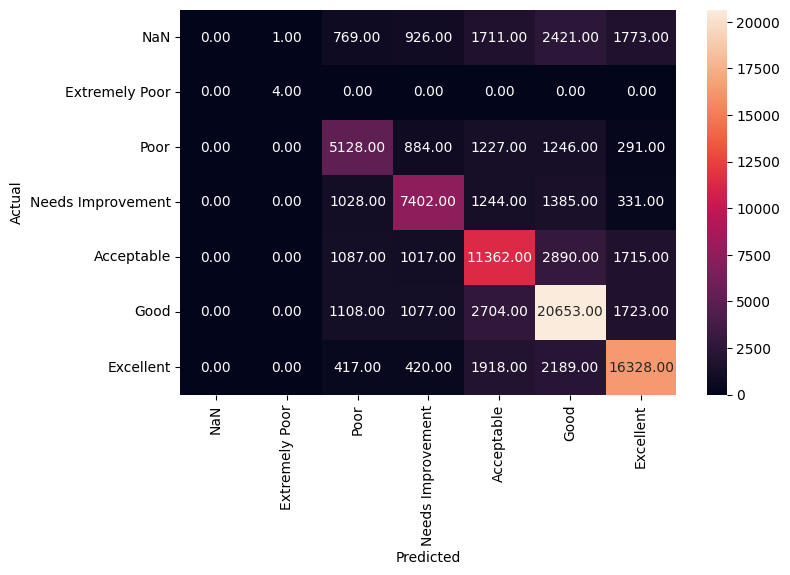

              precision    recall  f1-score   support

        -1.0   0.000000  0.000000  0.000000      7601
         0.0   0.800000  1.000000  0.888889         4
         1.0   0.480972  0.509799  0.494966      8776
         2.0   0.577203  0.591747  0.584385     11390
         3.0   0.514144  0.573294  0.542110     18071
         4.0   0.628948  0.727379  0.674592     27265
         5.0   0.712430  0.727200  0.719739     21272

    accuracy                       0.602666     94379
   macro avg   0.530528  0.589917  0.557812     94379
weighted avg   0.555131  0.602666  0.577491     94379



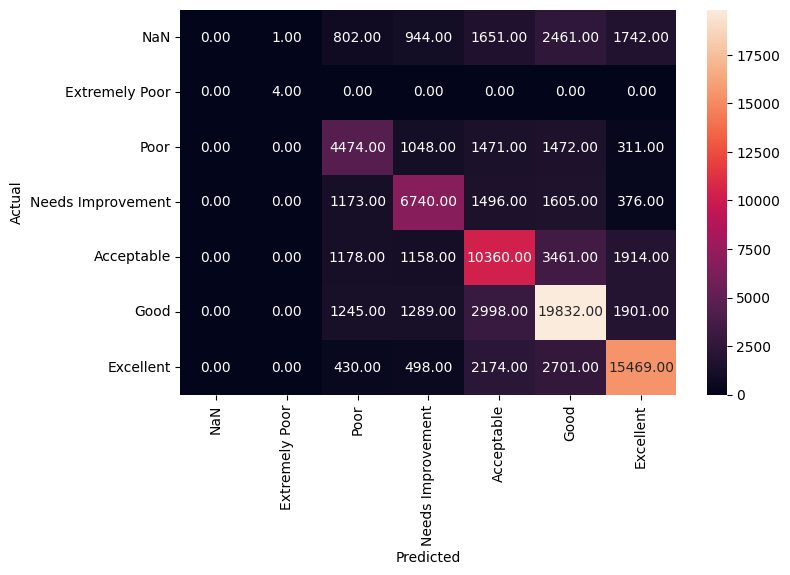

In [ ]:
# Checking performance on the all data
x_final_test = final_all[columns].fillna(-1)
y_final_test = final_all[target_column].fillna(-1)

y_pred_test_xgb_m = xgb_m.predict(x_final_test)
y_pred_test_xgb_cv = xgb_cv.predict(x_final_test)

all_xgbm_acc = metrics_score(y_final_test, y_pred_test_xgb_m, target_column)
all_xgbcv_acc = metrics_score(y_final_test, y_pred_test_xgb_cv, target_column)

### Update data based on models above.

In [ ]:
# Update data based on the model where missing values are.
x_final_all = final_all.loc[indices_all[target_column], columns]
x_final_test = final_test.loc[indices_test[target_column], columns]
# Which model to use? Choose the one with the best average accuacy!
x_final_model = max({
    rf: (test_rf_acc + all_rf_acc) ,
    xgb_m: (test_xgbm_acc + all_xgbm_acc),
    xgb_cv: (test_xgbcv_acc + all_xgbcv_acc)
  }.items(),
  key=lambda x: x[1]
)[0]
final_df.update(
    pd.Series(
        x_final_model.predict(x_final_all),
        name=target_column
    ).set_axis(indices_all[target_column]), # indices to update
)
final_all.update(
    pd.Series(
        x_final_model.predict(x_final_all),
        name=target_column
    ).set_axis(indices_all[target_column]), # indices to update
)
final_test.update(
    pd.Series(
        x_final_model.predict(x_final_test),
        name=target_column
    ).set_axis(indices_test[target_column]), #indices to update
)

In [ ]:
final_df.isna().sum().sum(),final_test.isna().sum().sum(),final_all.isna().sum().sum()

(0, 0, 0)

## **Splitting the dataset**


In [ ]:
# We need to encode the just modelled variables with the dummie method if it has been selected.
if encoding_method == 'get_dummies':
    # First back-transfer to original string.
    decode_binary = { 'Customer_Type': ['Loyal Customer', 'Disloyal Customer'], 'Type_Travel': ['Personal Travel', 'Business Travel']}
    final_df = final_df.assign(**{
      col: lambda x, c=col: [decode_binary[c][y] for y in x[c]] for col in defer_columns[0:2] if col in final_df.columns
    })
    final_test = final_test.assign(**{
      col: lambda x, c=col: [decode_binary[c][y] for y in x[c]] for col in defer_columns[0:2] if col in final_test.columns
    })
    final_all = final_all.assign(**{
      col: lambda x, c=col: [decode_binary[c][y] for y in x[c]] for col in defer_columns[0:2] if col in final_all.columns
    })
    final_df = final_df.assign(**{
      col: lambda x, c=col: [numeric_to_rating(y) for y in x[c]] for col in defer_columns[2:] if col in final_df.columns
    })
    final_test = final_test.assign(**{
      col: lambda x, c=col: [numeric_to_rating(y) for y in x[c]] for col in defer_columns[2:] if col in final_test.columns
    })
    final_all = final_all.assign(**{
      col: lambda x, c=col: [numeric_to_rating(y) for y in x[c]] for col in defer_columns[2:] if col in final_all.columns
    })
    # Then apply the get_dummies method.
    final_df = pd.get_dummies(final_df, columns=defer_columns, dtype=int)
    final_test = pd.get_dummies(final_test, columns=defer_columns, dtype=int)
    final_all = pd.get_dummies(final_all, columns=defer_columns, dtype=int)
    # Add zero columns to data frames with missing columns after call to get_dummie (where categorial values were missing)
    # Needed to make test dataset compatible.
    cols = set(final_test.columns).union(set(final_all.columns)).union(set(final_df.columns))
    cols.discard('Overall_Experience')
    final_df = final_df.assign(**{ col: 0 for col in cols.difference(set(final_df.columns.tolist())) })
    final_test = final_test.assign(**{ col: 0 for col in cols.difference(set(final_test.columns.tolist())) })
    final_all = final_all.assign(**{ col: 0 for col in cols.difference(set(final_all.columns.tolist())) })
    # Also remove spaces in new column names to be in sync to other column names.
    final_df.rename(columns=lambda x: x.replace(" ","_"), inplace=True)
    final_test.rename(columns=lambda x: x.replace(" ","_"), inplace=True)
    final_all.rename(columns=lambda x: x.replace(" ","_"), inplace=True)

In [ ]:
# Create train and test datasets
pcnt = .7
target_column = 'Overall_Experience'

# Random state is a seed value
train = final_df.sample(frac = pcnt, random_state = 14)
test = final_df.drop(train.index)

columns = final_df.columns.to_list()
columns.remove(target_column)

x_train = train[columns]
x_test = test[columns]

y_train = train[target_column]
y_test = test[target_column]

np.random.seed(0)

## **Random Forest**

In [ ]:
rf = RandomForestClassifier(random_state = 1, criterion = 'entropy', class_weight = 'balanced')
rf = rf.fit(x_train, y_train)

              precision    recall  f1-score   support

           0   0.939795  0.955631  0.947647     12937
           1   0.962135  0.948495  0.955266     15377

    accuracy                       0.951755     28314
   macro avg   0.950965  0.952063  0.951456     28314
weighted avg   0.951927  0.951755  0.951785     28314



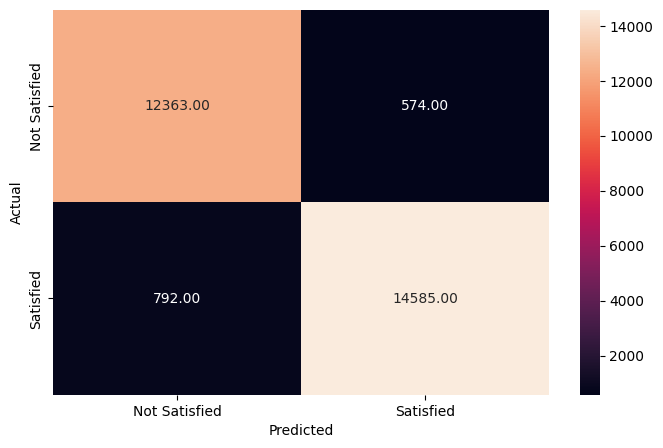

In [ ]:
# Checking performance on the test data
y_pred_test_rf_tuned = rf.predict(x_test)

test_rf_acc = metrics_score(y_test, y_pred_test_rf_tuned, target_column)

              precision    recall  f1-score   support

           0   0.981583  0.986584  0.984077     42786
           1   0.988827  0.984649  0.986734     51593

    accuracy                       0.985526     94379
   macro avg   0.985205  0.985617  0.985406     94379
weighted avg   0.985543  0.985526  0.985530     94379



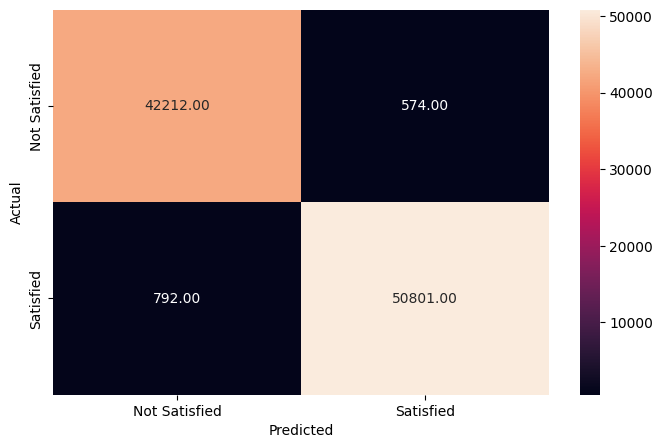

In [ ]:
# Checking performance on the all data
x_final_test = final_all[columns]
y_final_test = final_all['Overall_Experience']

y_pred_test_rf_tuned = rf.predict(x_final_test)

all_rf_acc = metrics_score(y_final_test, y_pred_test_rf_tuned, target_column)

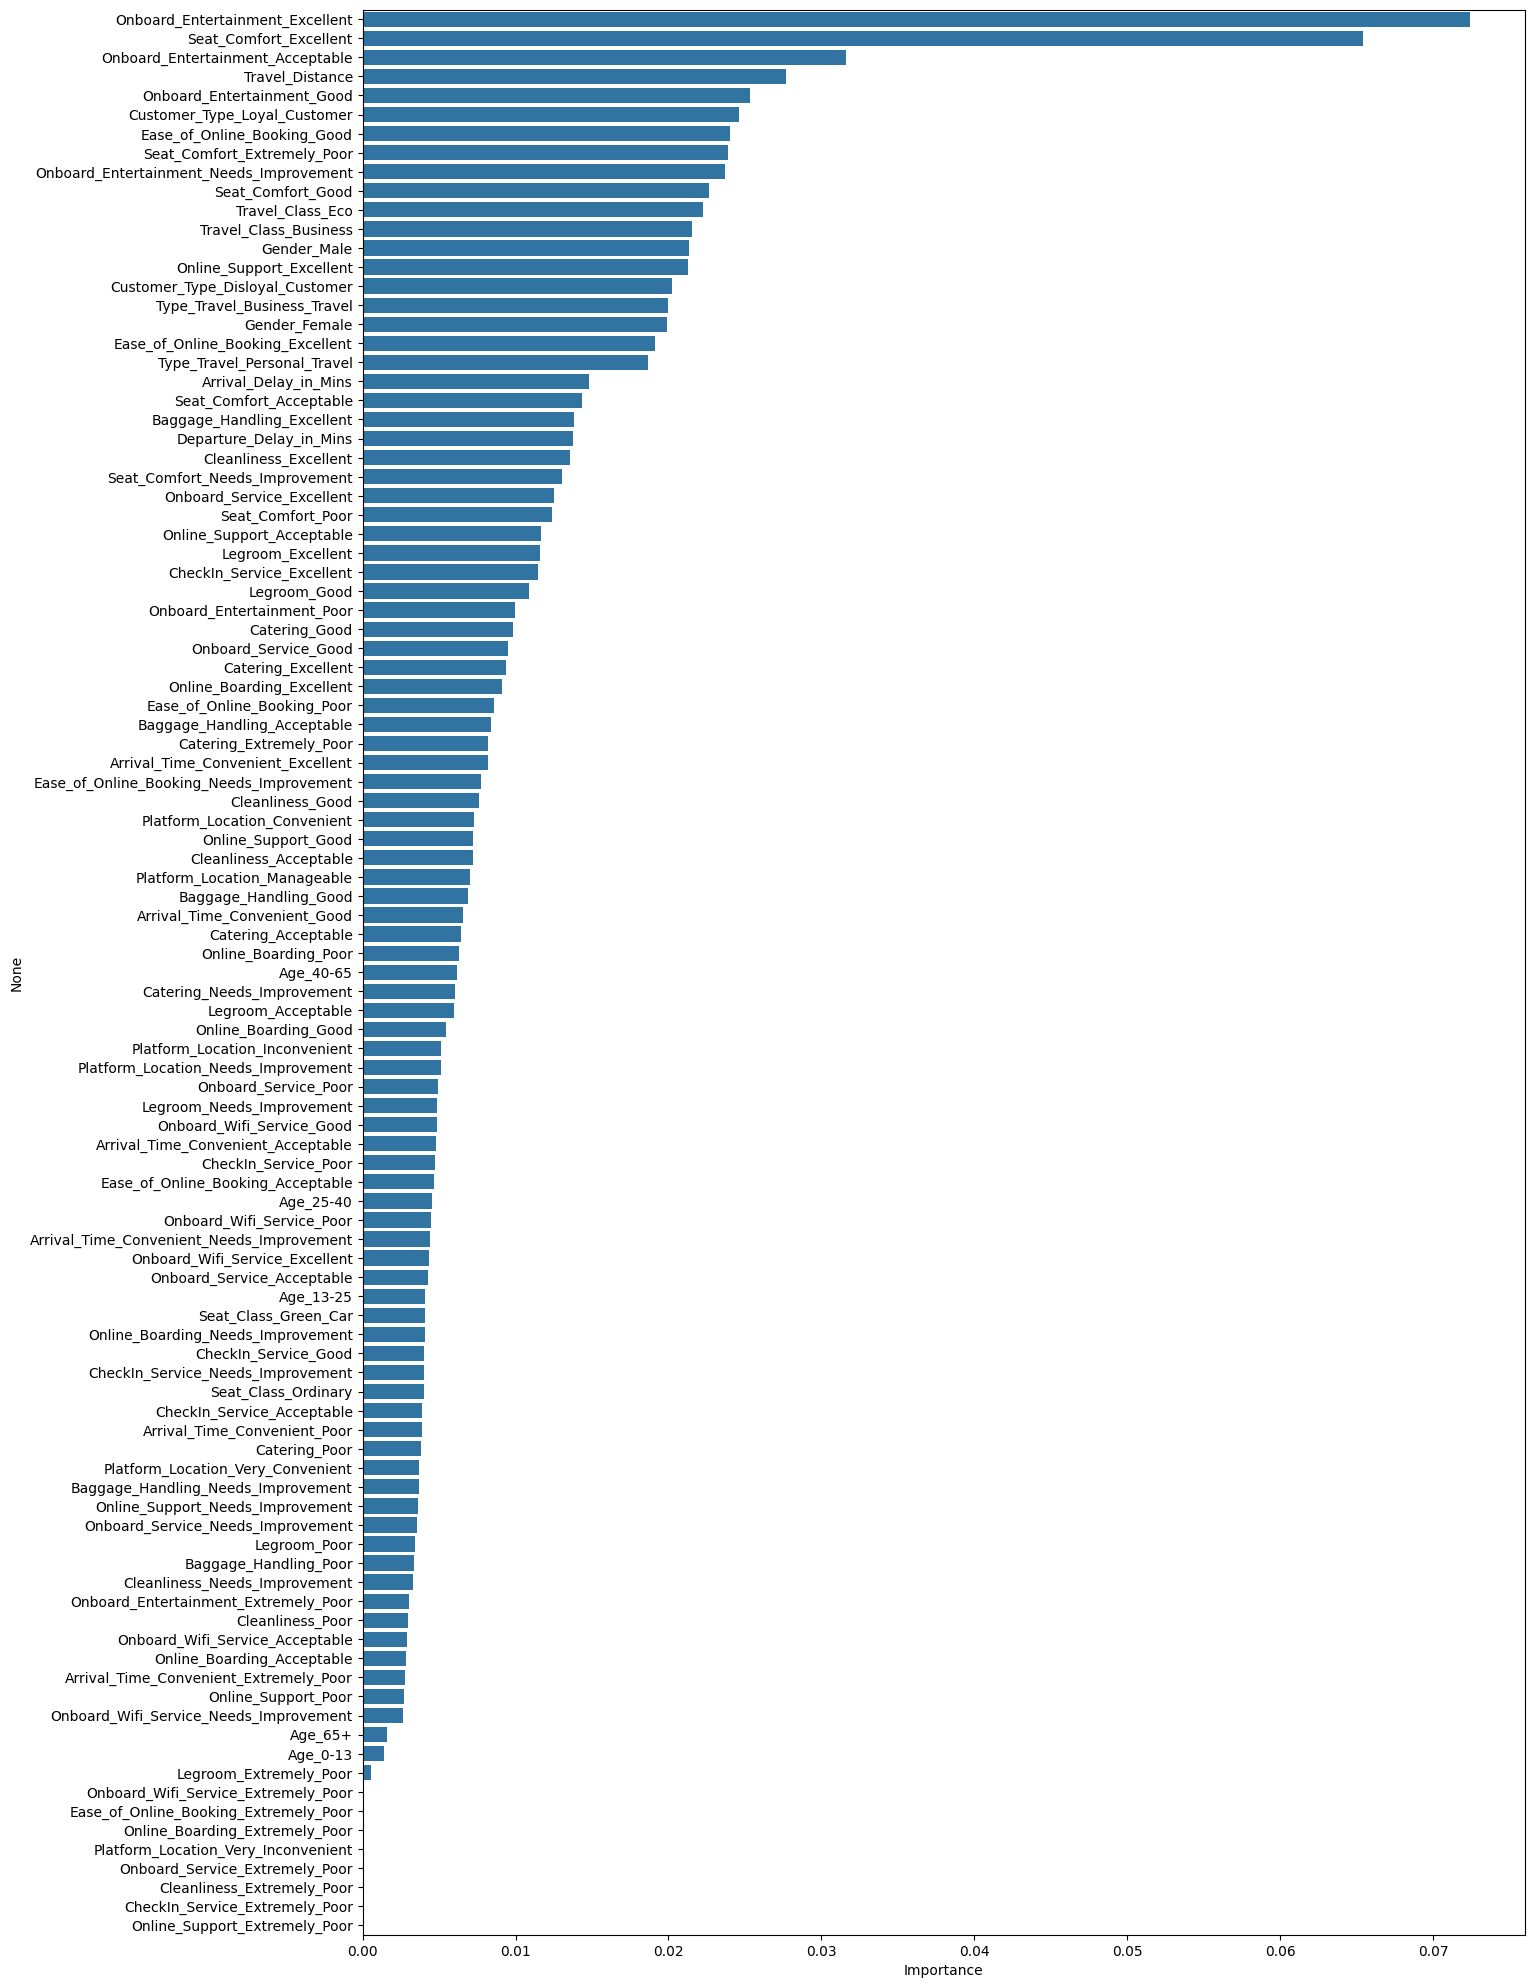

In [ ]:
# Plot the feature importance

importances = rf.feature_importances_

importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (15, 25) if encoding_method == 'get_dummies' else (10, 10))

sns.barplot(x=importance_df.Importance,y=importance_df.index);

In [ ]:
prediction = pd.DataFrame({'ID' : final_test.index, 'Overall_Experience': rf.predict(final_test[columns])})
prediction.to_csv(results_directory + 'submission_rf_' + ( 'GD' if encoding_method == 'get_dummies' else 'FR2N') + '_v17.csv', index = False)

## **XGBoost**

In [ ]:
# Fitting the XGBoost-model
# Method 1) Use Cross-Validation on the dataset to find the best model.
X = final_df[columns]
y = final_df[target_column]

# cross-validator.
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=5)

# XGBoost Classifier
xgb_cv = XGBClassifier(
  random_state = 1,
  eval_metric = "logloss", # For multi-class use mlogloss
  tree_method = "hist",
  early_stopping_rounds = 4, # low number to avoid overfitting
)

# Pick the best from the cross validation above
xgb_cv = simple_XGB_optimation(xgb_cv, X, y, cv)

# Method 2) Use the current train/test chunks
xgb_m = XGBClassifier(random_state = 1, eval_metric = "logloss")
xgb_m = xgb_m.fit(x_train, y_train)

[0]	validation_0-logloss:0.52205
[1]	validation_0-logloss:0.43123
[2]	validation_0-logloss:0.37422
[3]	validation_0-logloss:0.33224
[4]	validation_0-logloss:0.29510
[5]	validation_0-logloss:0.26556
[6]	validation_0-logloss:0.23944
[7]	validation_0-logloss:0.22336
[8]	validation_0-logloss:0.20859
[9]	validation_0-logloss:0.19560
[10]	validation_0-logloss:0.18649
[11]	validation_0-logloss:0.17831
[12]	validation_0-logloss:0.17230
[13]	validation_0-logloss:0.16882
[14]	validation_0-logloss:0.16421
[15]	validation_0-logloss:0.15820
[16]	validation_0-logloss:0.15661
[17]	validation_0-logloss:0.15373
[18]	validation_0-logloss:0.15149
[19]	validation_0-logloss:0.14716
[20]	validation_0-logloss:0.14611
[21]	validation_0-logloss:0.14357
[22]	validation_0-logloss:0.14121
[23]	validation_0-logloss:0.13820
[24]	validation_0-logloss:0.13670
[25]	validation_0-logloss:0.13638
[26]	validation_0-logloss:0.13381
[27]	validation_0-logloss:0.13094
[28]	validation_0-logloss:0.13059
[29]	validation_0-loglos

              precision    recall  f1-score   support

           0   0.942599  0.951998  0.947275     12937
           1   0.959273  0.951226  0.955233     15377

    accuracy                       0.951579     28314
   macro avg   0.950936  0.951612  0.951254     28314
weighted avg   0.951655  0.951579  0.951597     28314



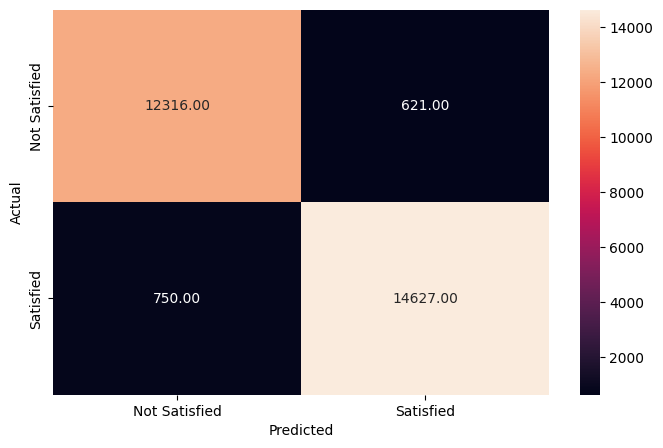

              precision    recall  f1-score   support

           0   0.954126  0.967844  0.960936     12937
           1   0.972615  0.960851  0.966697     15377

    accuracy                       0.964046     28314
   macro avg   0.963371  0.964347  0.963817     28314
weighted avg   0.964168  0.964046  0.964065     28314



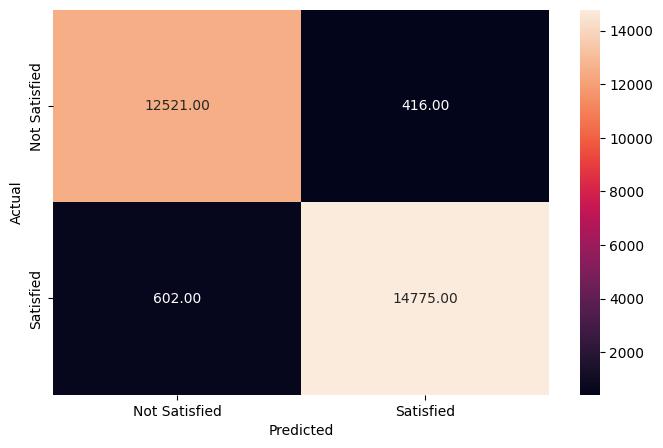

In [ ]:
# Checking performance on the test data
y_pred_test_xgb_m = xgb_m.predict(x_test)
y_pred_test_xgb_cv = xgb_cv.predict(x_test)

test_xgbm_acc = metrics_score(y_test, y_pred_test_xgb_m, target_column)
test_xgbcv_acc = metrics_score(y_test, y_pred_test_xgb_cv, target_column)

              precision    recall  f1-score   support

           0   0.957596  0.969055  0.963292     42786
           1   0.974080  0.964414  0.969223     51593

    accuracy                       0.966518     94379
   macro avg   0.965838  0.966735  0.966257     94379
weighted avg   0.966607  0.966518  0.966534     94379



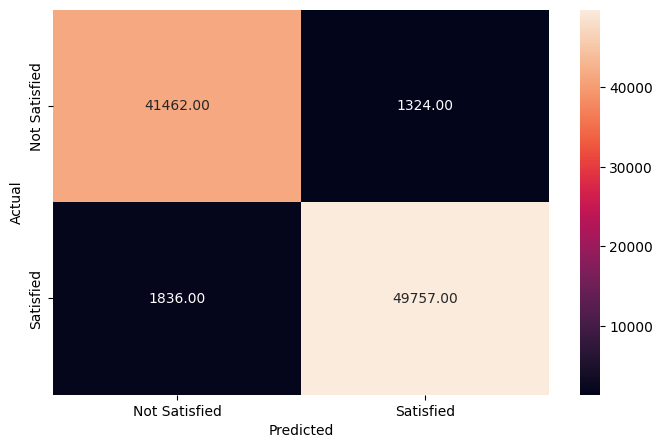

              precision    recall  f1-score   support

           0   0.954822  0.968658  0.961690     42786
           1   0.973692  0.961991  0.967806     51593

    accuracy                       0.965013     94379
   macro avg   0.964257  0.965324  0.964748     94379
weighted avg   0.965137  0.965013  0.965033     94379



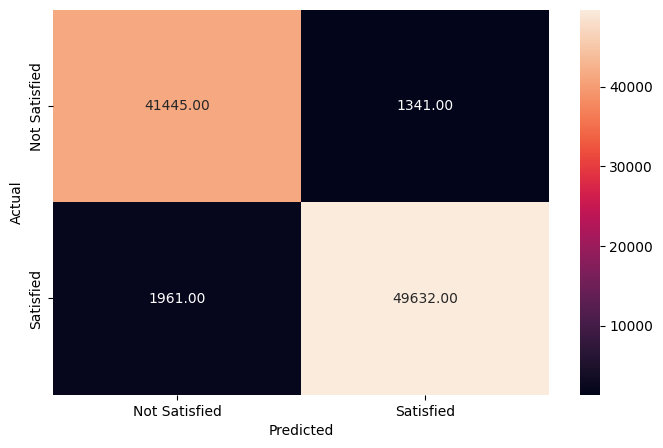

In [ ]:
# Checking performance on the all data
x_final_test = final_all[columns].fillna(-1)
y_final_test = final_all[target_column].fillna(-1)

y_pred_test_xgb_m = xgb_m.predict(x_final_test)
y_pred_test_xgb_cv = xgb_cv.predict(x_final_test)

all_xgbm_acc = metrics_score(y_final_test, y_pred_test_xgb_m, target_column)
all_xgbcv_acc = metrics_score(y_final_test, y_pred_test_xgb_cv, target_column)

In [ ]:
prediction = pd.DataFrame({'ID' : final_test.index, 'Overall_Experience': xgb_m.predict(final_test[columns])})
prediction.to_csv(results_directory + 'submission_xgbm_' + ( 'GD' if encoding_method == 'get_dummies' else 'FR2N') + '_v17.csv', index = False)
prediction = pd.DataFrame({'ID' : final_test.index, 'Overall_Experience': xgb_cv.predict(final_test[columns])})
prediction.to_csv(results_directory + 'submission_xgbcv_' + ( 'GD' if encoding_method == 'get_dummies' else 'FR2N') + '_v17.csv', index = False)

In [ ]:
pd.DataFrame({
    'Random Forest': [test_rf_acc , all_rf_acc, (test_rf_acc + all_rf_acc)/2.0],
    'XGBoost Manual': [test_xgbm_acc, all_xgbm_acc, (test_xgbm_acc + all_xgbm_acc)/2.0],
    'XGBoost CV': [test_xgbcv_acc, all_xgbcv_acc, (test_xgbcv_acc + all_xgbcv_acc)/2.0]
  },
  columns = pd.Index(['Random Forest','XGBoost Manual', 'XGBoost CV'], name='Model:'),
  index = pd.Index(['Test Data','All Data', 'Average'], name='Data Source'),
).style.format('{:.3f}')